# Imports

In [3]:
#manipulação de dados
import pandas as pd
import numpy  as np

#visualização
import matplotlib.pyplot as plt
import seaborn           as sns
from IPython.core.display import HTML
import umap.umap_ as umap

#metricas
import sklearn.metrics
import scikitplot                          as skplt
from scipy                 import stats
from sklearn               import manifold as mn
from yellowbrick.cluster   import KElbowVisualizer, SilhouetteVisualizer

# processamento de dados
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import pickle

#modelos
from sklearn.ensemble     import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn              import mixture      as mx
from scipy.cluster        import hierarchy     as hr
from sklearn.neighbors    import NearestNeighbors
from sklearn              import decomposition as  dcp
from sklearn              import cluster       as c

## Helper functions

In [4]:
# configuração do jupyter notebook e plotagem de imagens
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    sns.set()
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [5]:
import warnings
warnings.filterwarnings("ignore")

In [88]:
def calculate_confidence_intervals(columns, dataframe, alpha=0.5):
    """
    Calculate the confidence intervals for the specified columns in a DataFrame.

    Parameters:
    - columns: A list of strings containing the names of the columns for which the confidence intervals should be calculated.
    - dataframe: The DataFrame containing the data.
    - alpha: The significance level used to calculate the confidence intervals. Defaults to 0.5 (corresponding to a 50% confidence level).

    Returns:
    - A dictionary containing the confidence intervals for each specified column.

    """
    from scipy import stats as st
    import numpy as np
    
    confidence_intervals = {}

    for column in columns:
        data = dataframe[column]
        confidence_interval = st.t.interval(alpha=alpha, df=len(data)-1, loc=np.mean(data), scale=st.sem(data))
        confidence_intervals[column] = confidence_interval

    return confidence_intervals


# Load data 

In [8]:
path_local = '/home/lavino/Documentos/projetos_pessoais/ifood_data_analyst_challenge/'

In [9]:
df7 = pd.read_csv(path_local + 'data/processed/df5.csv')

In [10]:
df7.head()

,id,marital_status,income,recency,mnt_wines,mnt_fruits,mnt_meat_products,mnt_fish_products,mnt_sweet_products,mnt_gold_prods,...,accepted_cmp3,accepted_cmp5,accepted_cmp1,age,n_family_members,days_since_signup,income_per_member,total_spent,total_accepted,response
0,5524,0.22,0.351086,0.585859,0.425318,0.442211,0.554878,0.664093,0.335878,0.274143,...,0,0,0,0.696429,1,0.948498,0.373613,0.639683,0,1
1,2174,0.22,0.277680,0.383838,0.007368,0.005025,0.006098,0.007722,0.003817,0.018692,...,0,0,0,0.750000,3,0.161660,0.094444,0.008730,0,0
2,4141,0.25,0.434956,0.262626,0.285332,0.246231,0.129065,0.428571,0.080153,0.130841,...,0,0,0,0.553571,2,0.446352,0.227577,0.305952,0,0
3,6182,0.25,0.155079,0.262626,0.007368,0.020101,0.020325,0.038610,0.011450,0.015576,...,0,0,0,0.214286,3,0.198856,0.051506,0.019048,0,0
4,5324,0.39,0.352051,0.949495,0.115874,0.216080,0.119919,0.177606,0.103053,0.046729,...,0,0,0,0.267857,3,0.230329,0.120491,0.165476,0,0


# Select columns 

**Para a segmentação de clientes algumas variaveis serão deixadas de lado nesse momento**

In [11]:
df_ref = df7[['id','response']]

In [12]:
cols_selected = ['id','income', 'recency', 'mnt_wines', 'mnt_fruits',
       'mnt_meat_products', 'mnt_fish_products', 'mnt_sweet_products',
       'mnt_gold_prods', 'num_deals_purchases', 'num_web_purchases',
       'num_catalog_purchases', 'num_store_purchases', 'num_web_visits_month',
       'age','n_family_members', 'days_since_signup', 'income_per_member',
       'total_spent']
df8 = df7[cols_selected]

# Estudo do espaço

In [13]:
X = df8.copy()
X = X.drop(columns='id')

## PCA

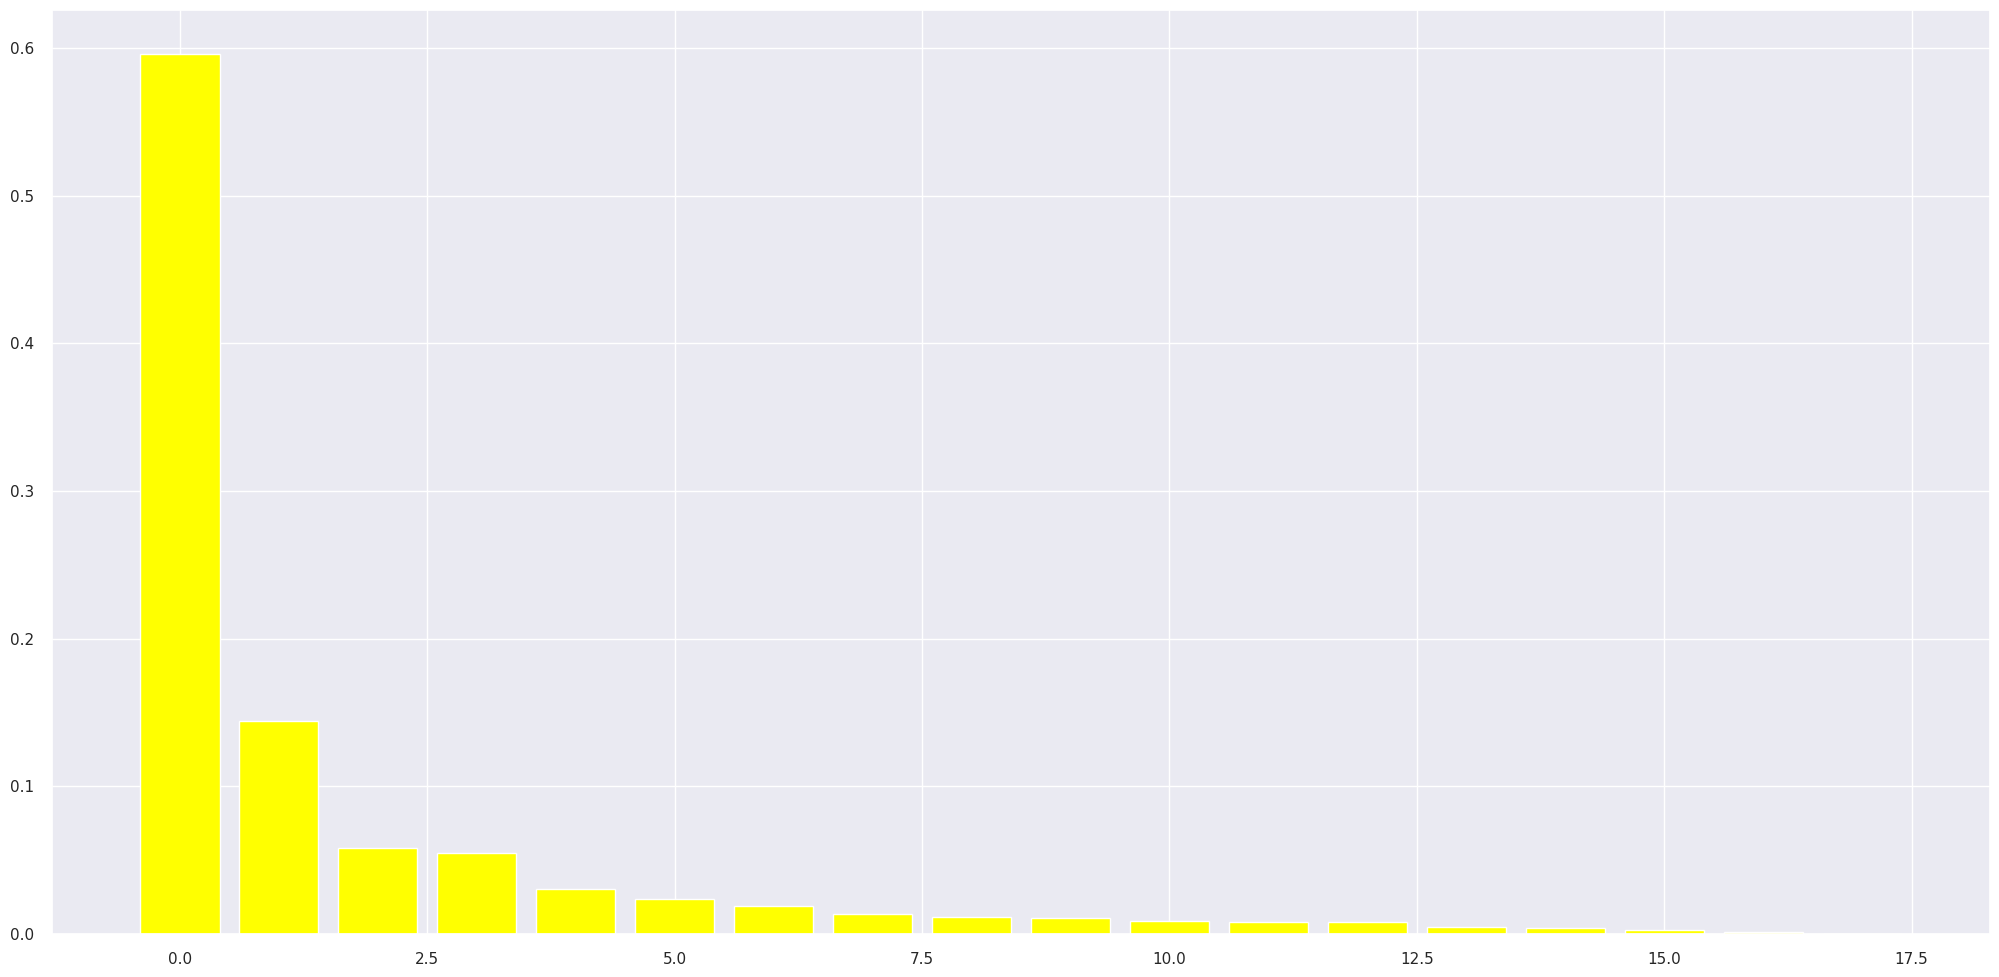

In [14]:
pca = dcp.PCA(n_components = X.shape[1])
principal_component = pca.fit_transform(X)

# plot explained variable

features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_ratio_,color='yellow')

#pcs componentes
df_pca = pd.DataFrame(principal_component)

<AxesSubplot: xlabel='0', ylabel='1'>

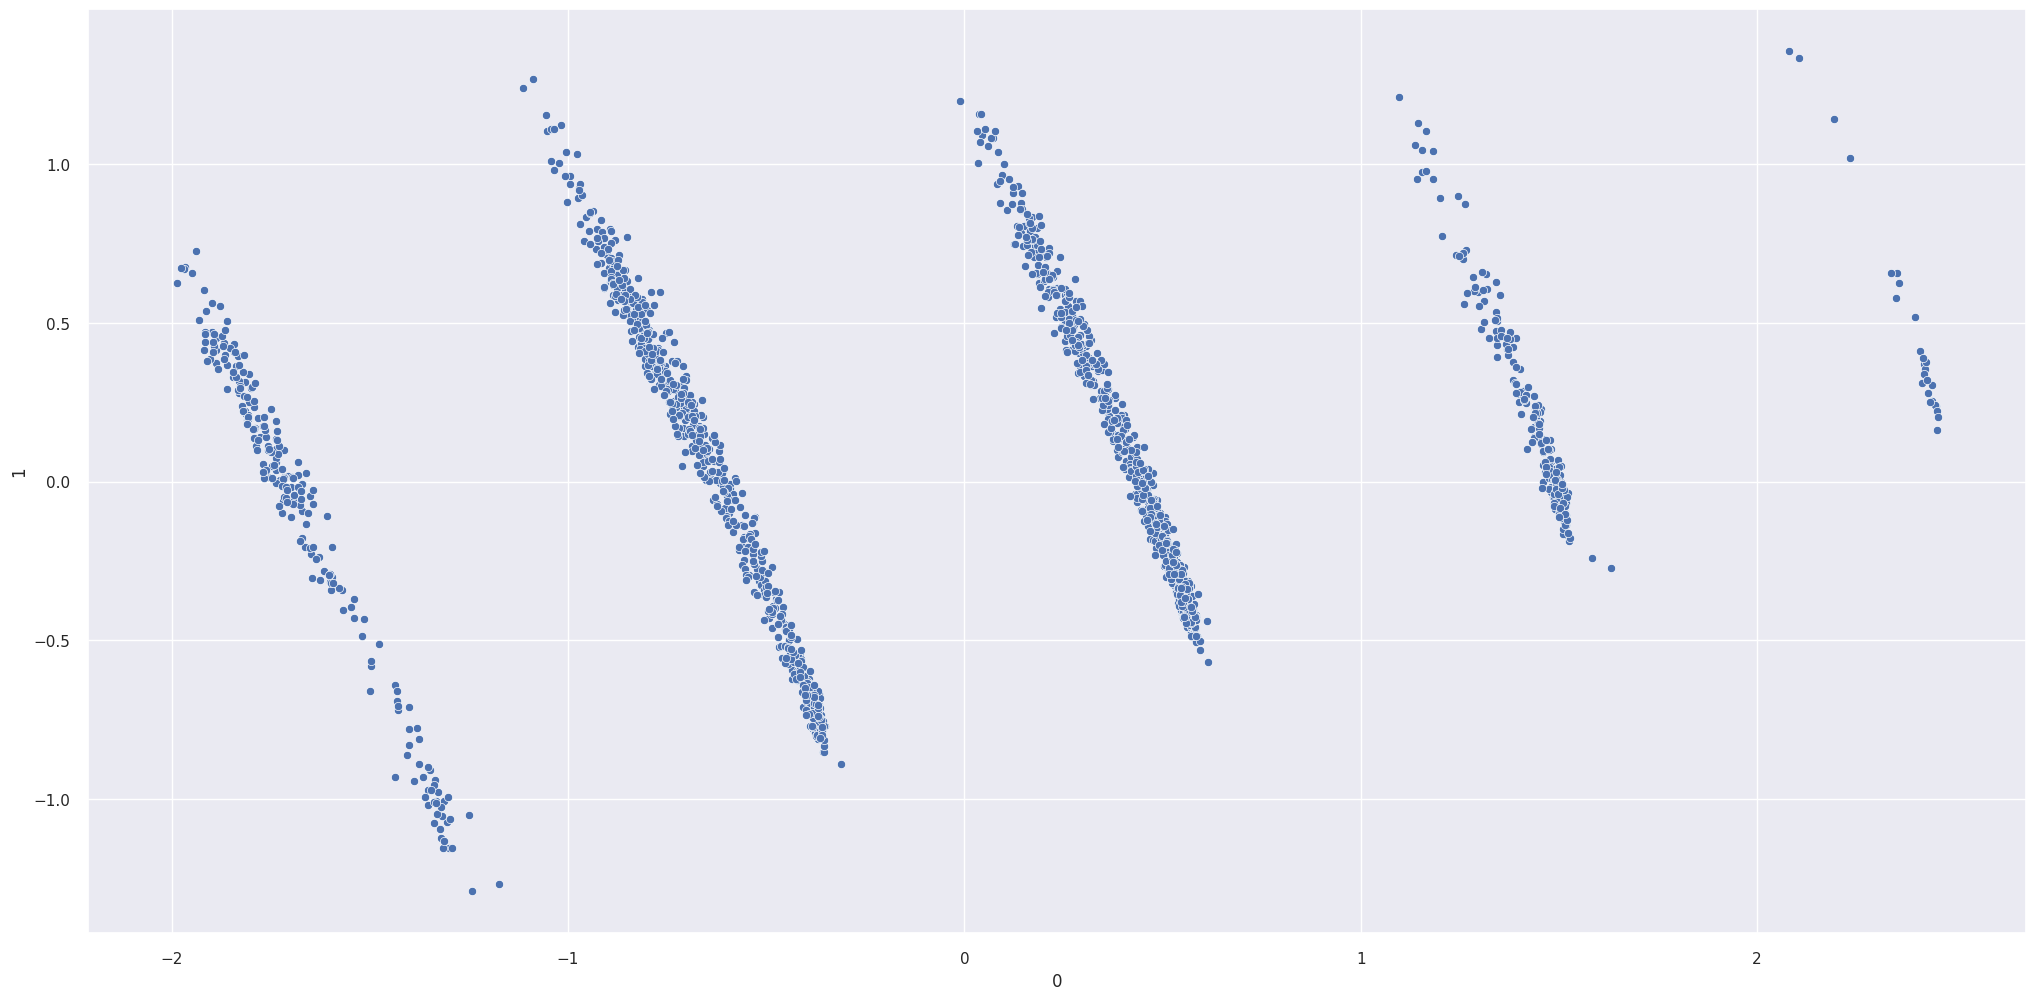

In [15]:
sns.scatterplot(x=0,y=1,data=df_pca)

## Umap

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

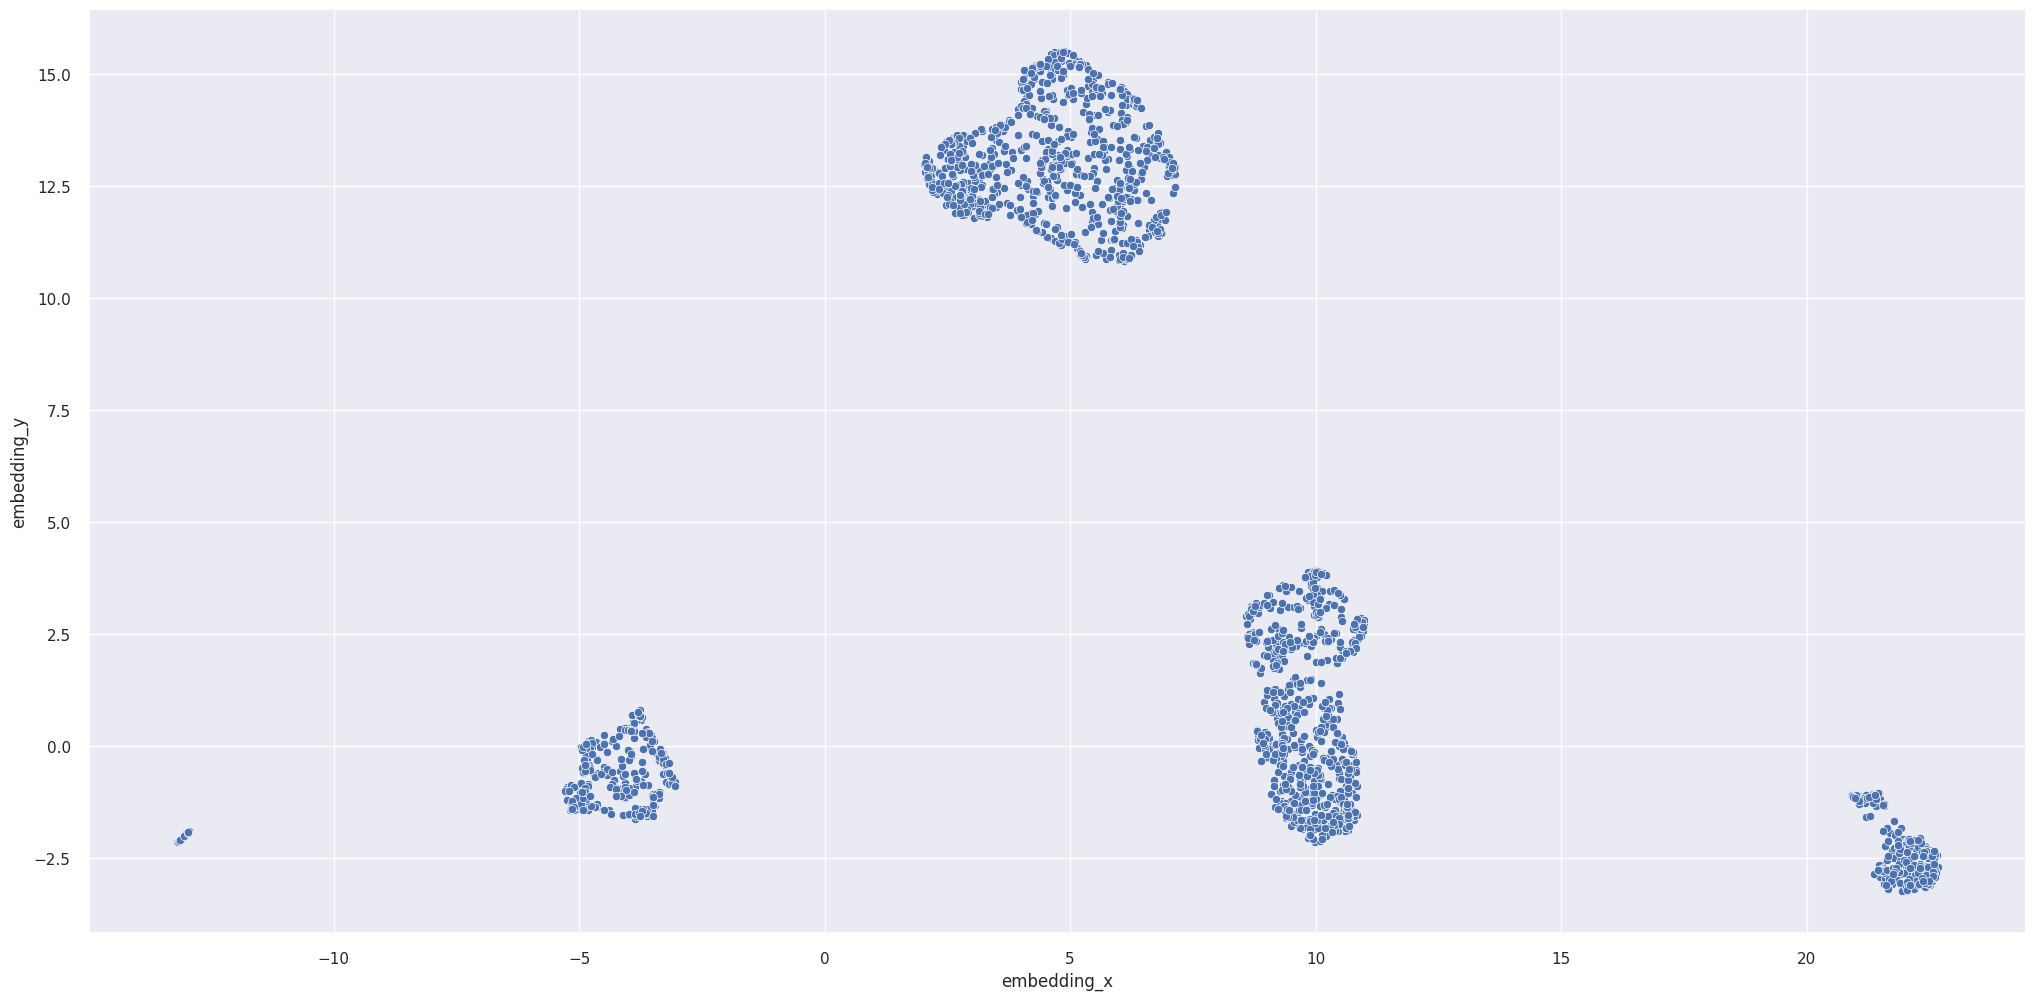

In [16]:
import umap.umap_ as umap
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)


#embedding
df_umap = pd.DataFrame()

df_umap['embedding_x'] = embedding[:,0]
df_umap['embedding_y'] = embedding[:,1]


sns.scatterplot(x='embedding_x', y ='embedding_y',data=df_umap)

## T-SNE

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

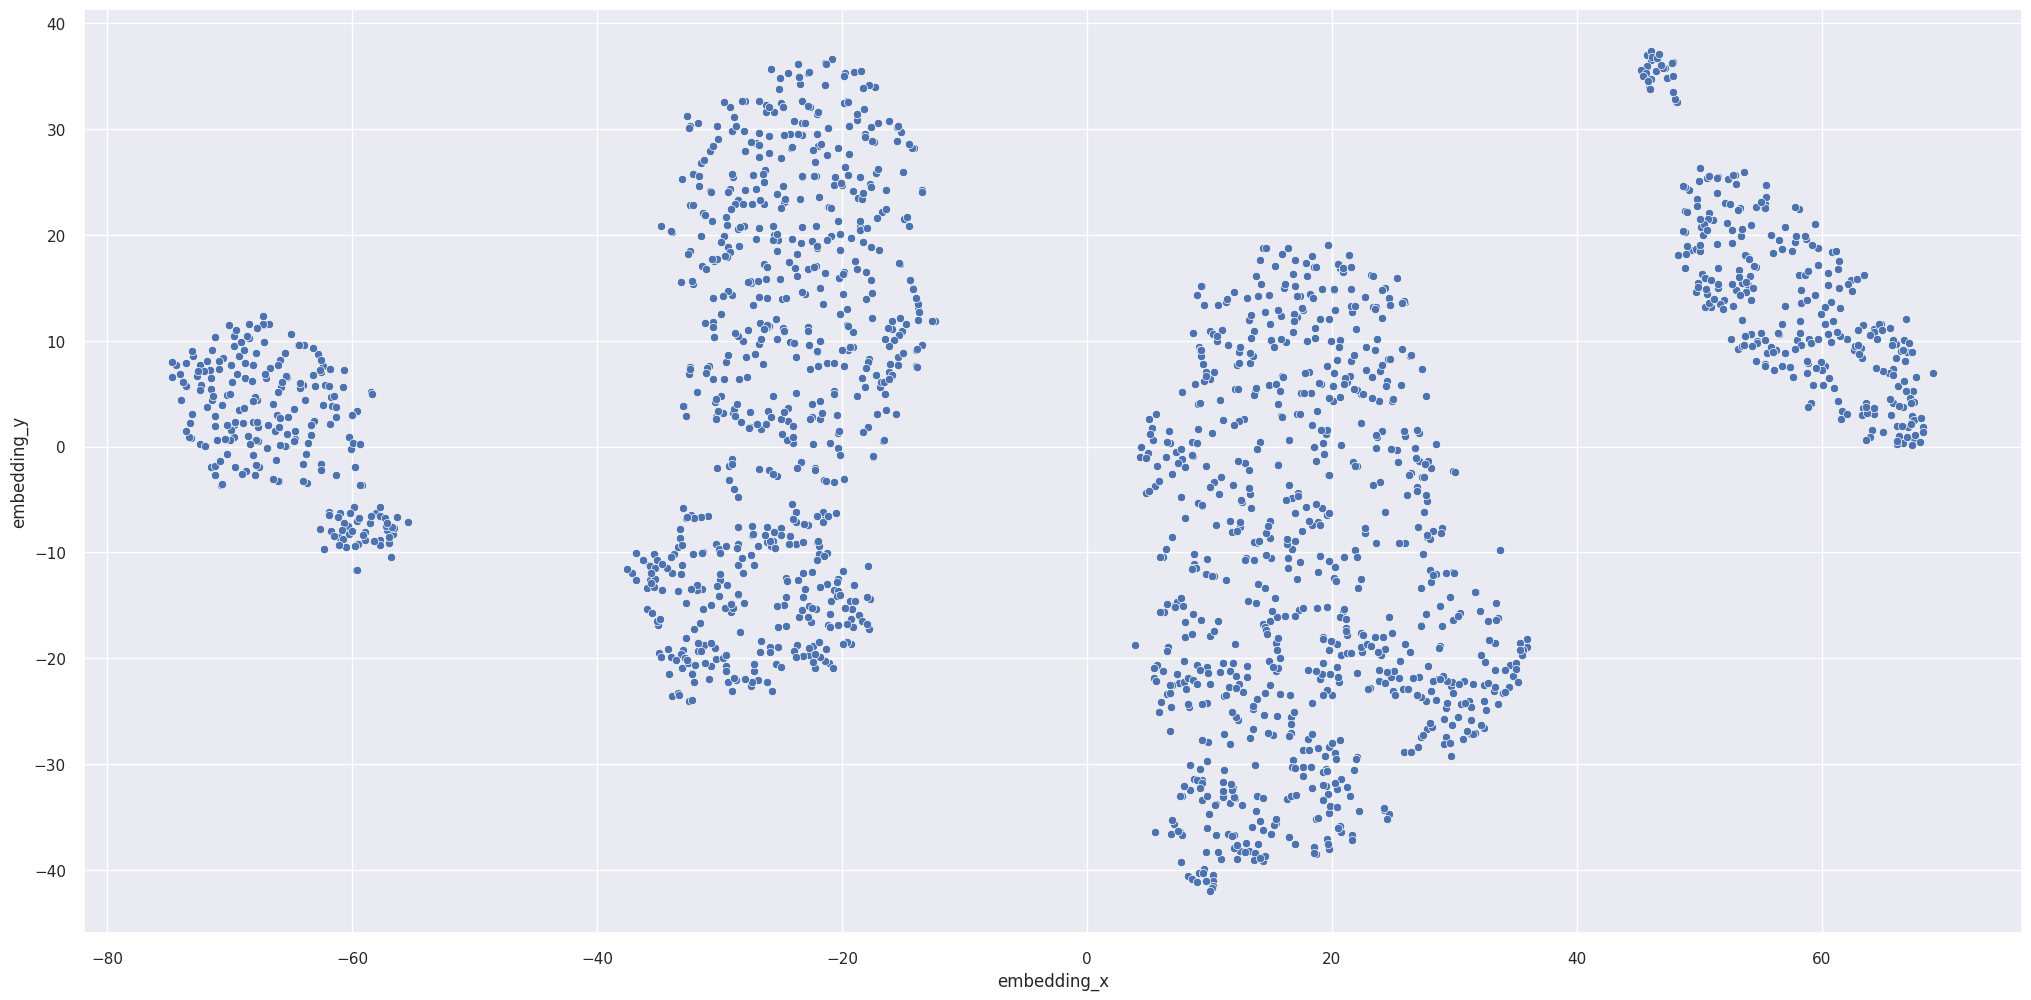

In [17]:
from sklearn.manifold import TSNE
reducer = TSNE(n_components=2,n_jobs=-1,random_state=42)
embedding = reducer.fit_transform(X)


#embedding
df_tsne = pd.DataFrame()

df_tsne['embedding_x'] = embedding[:,0]
df_tsne['embedding_y'] = embedding[:,1]


sns.scatterplot(x='embedding_x', y ='embedding_y',data=df_tsne)

## tree-based embedign

In [18]:
X = df8.drop(['id','total_spent'],axis=1)
y = df8['total_spent']


# model definition
rf_model = RandomForestRegressor(n_estimators=100,random_state=42)

#model training
rf_model.fit(X,y.values)

# Leaf
df_leaf = pd.DataFrame(rf_model.apply(X))
#dataframe Leaf

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

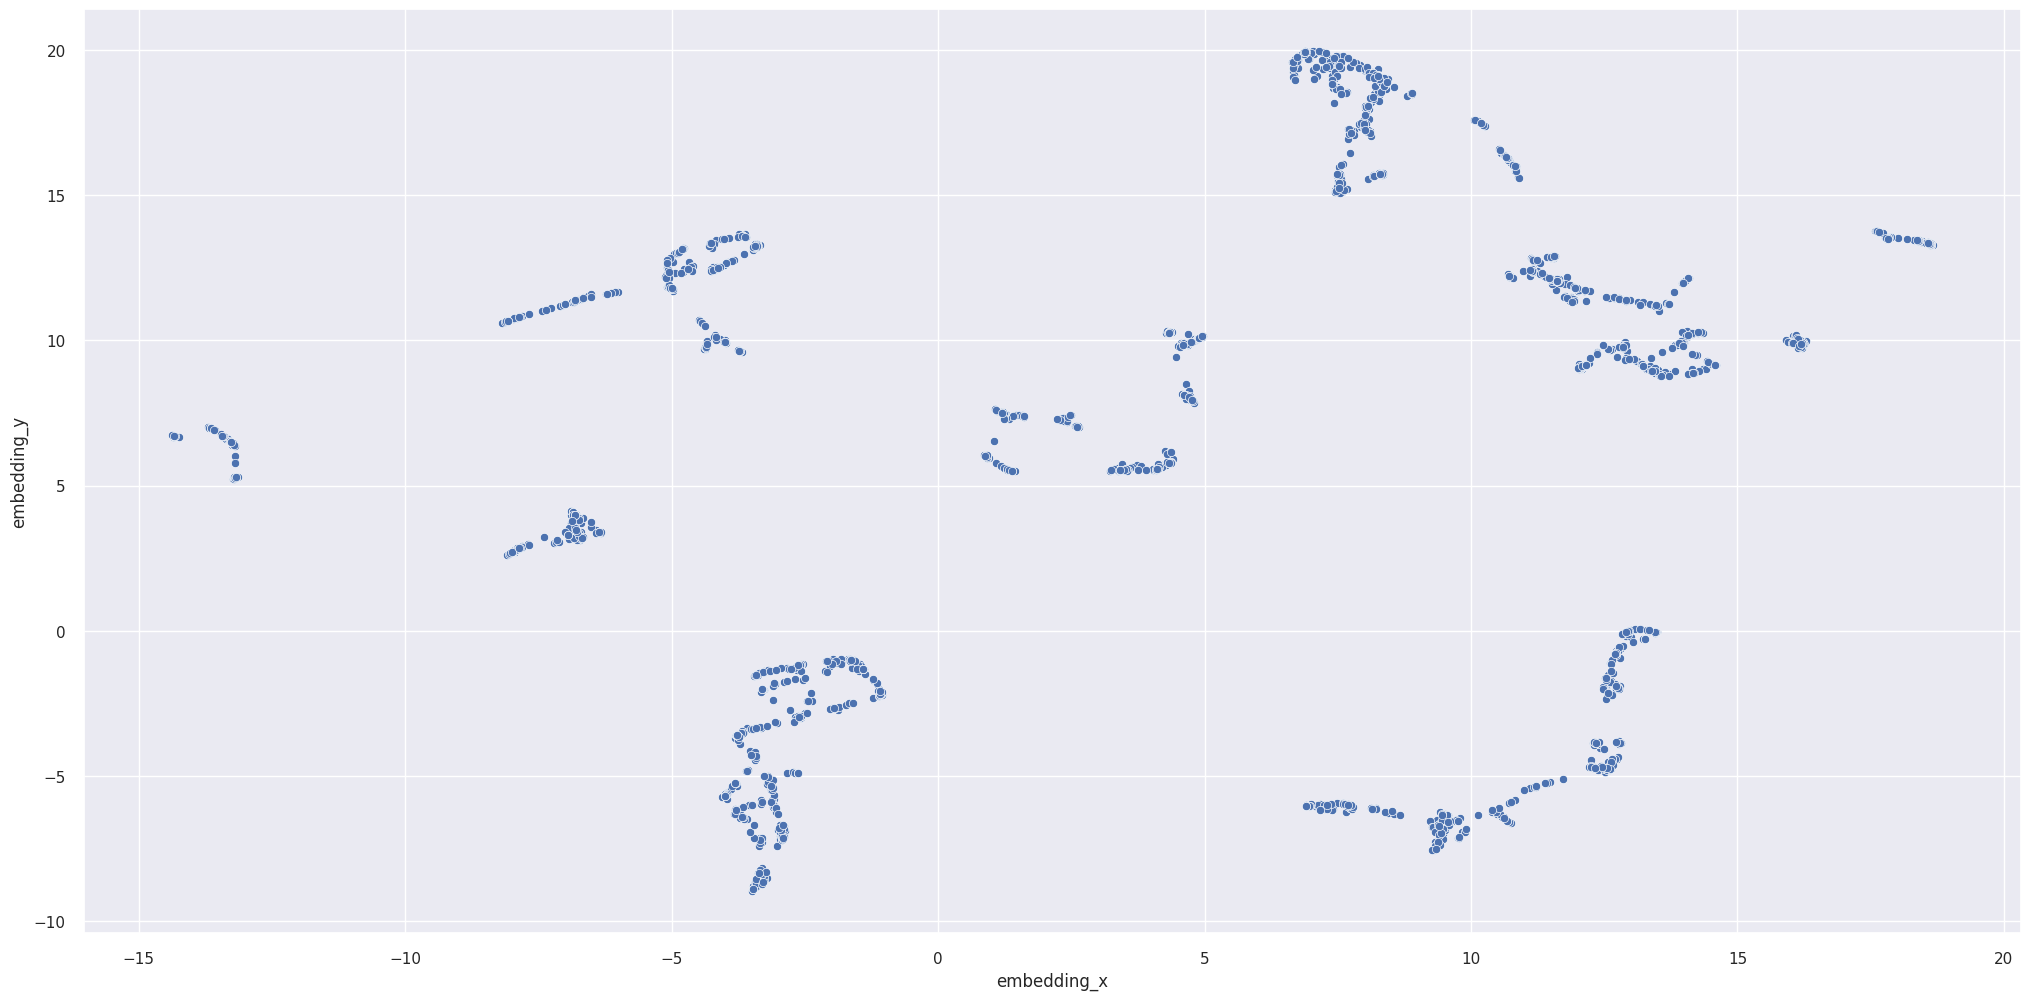

In [19]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_leaf)


#embedding

df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]


sns.scatterplot(x='embedding_x', y ='embedding_y',data=df_pca)

# Fine tuning 

In [20]:
#X = df8.drop(columns='id')
X = df_umap

In [21]:
X.head()

,embedding_x,embedding_y
0,22.681900,-2.701372
1,5.136178,11.091660
2,10.582907,0.076131
3,6.343331,11.308006
4,4.407497,14.477543


In [22]:
clusters = [2,3,4,5,6,7]

## k-means

In [23]:
sil_k = []
for k in clusters:
    # model definition
    k_model = c.KMeans(n_clusters=k)

    #model training
    k_model.fit(X)

    #model predict
    labels = k_model.predict(X)

    #model performace
    sil_k.append(sklearn.metrics.silhouette_score(X,labels,metric='euclidean'))

**Within-Cluster Sum of Square (WSS)**

In [24]:
wss = []
for k in clusters:
    # model definition
    kmeans = c.KMeans(init='random', n_clusters=k, n_init=10,max_iter=300,random_state=42)
    #model training
    kmeans.fit(X)
    
    wss.append(kmeans.inertia_)

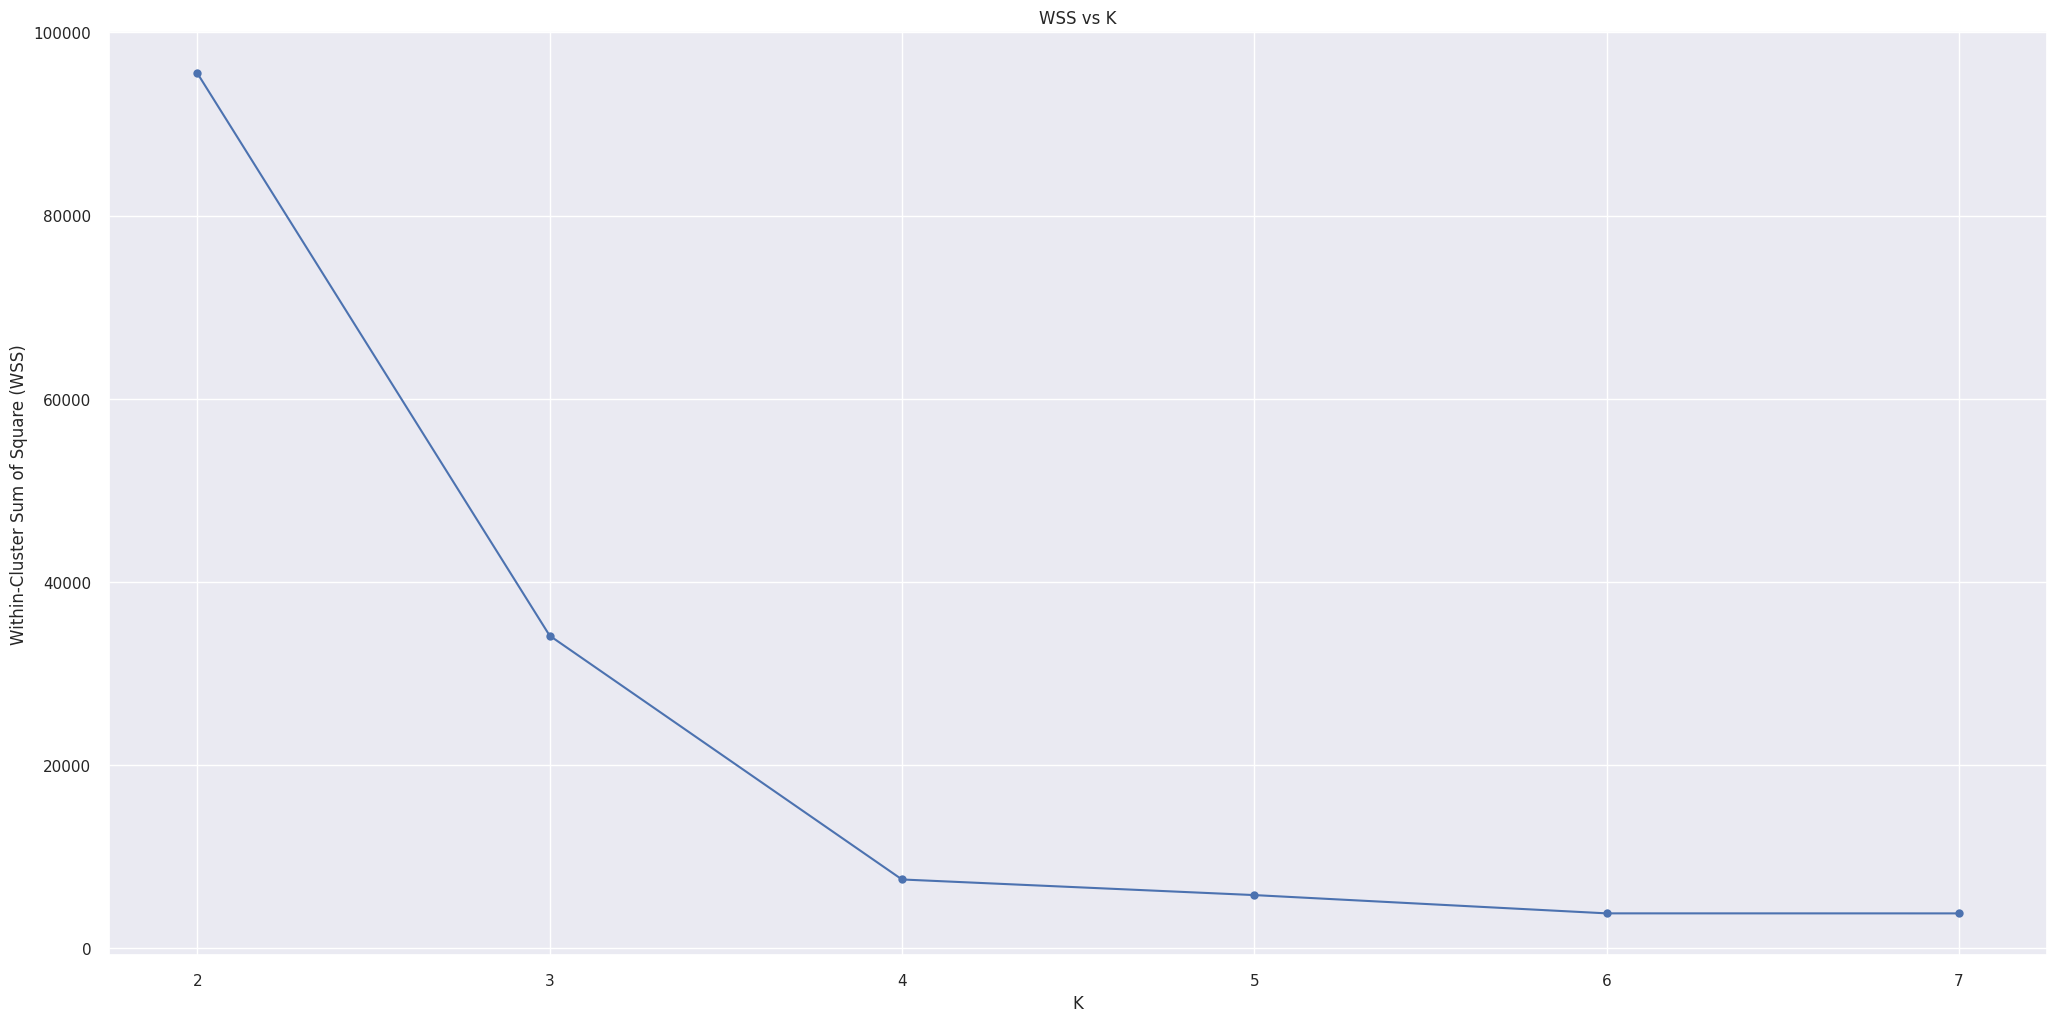

In [25]:
plt.plot(clusters,wss, marker = 'o');
plt.xlabel('K');
plt.ylabel('Within-Cluster Sum of Square (WSS)');
plt.title('WSS vs K');

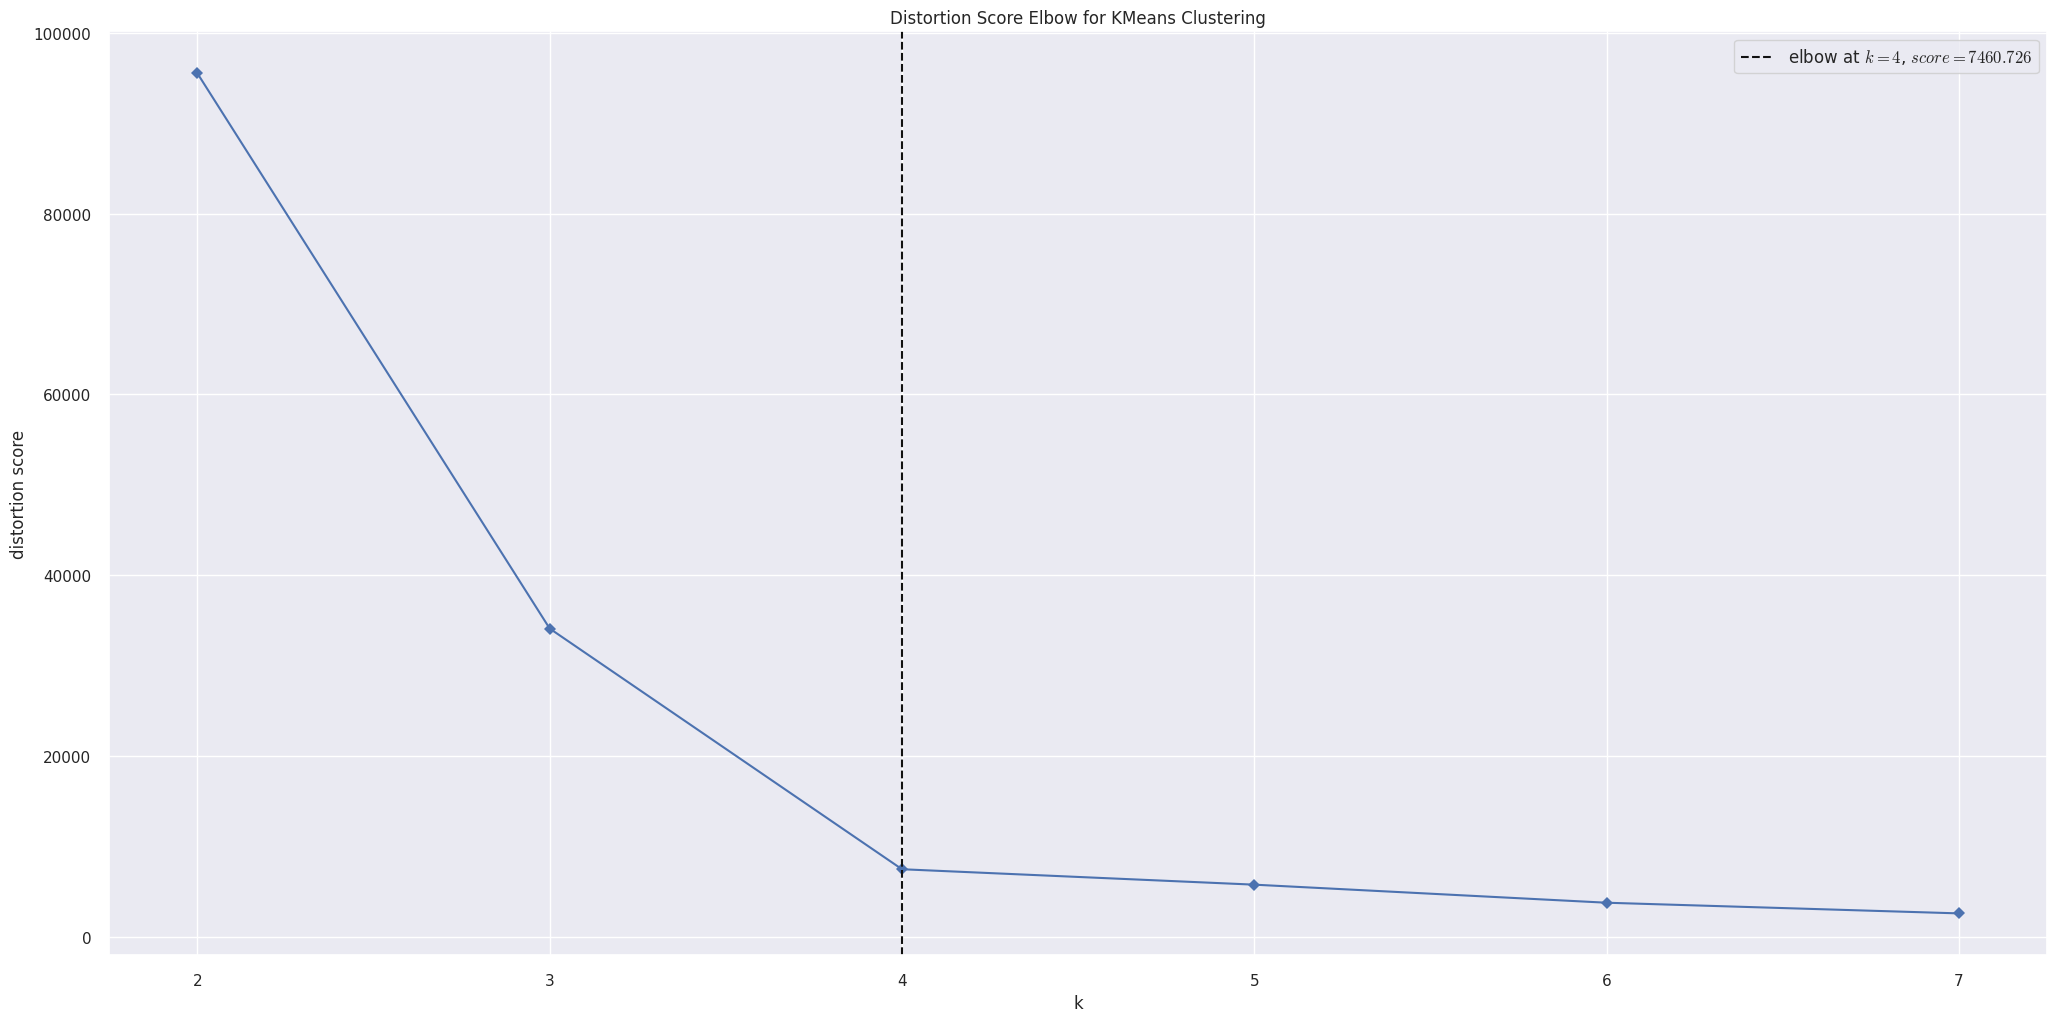

In [26]:
kmeans = KElbowVisualizer(c.KMeans(),k=clusters,timings=False)
kmeans.fit(X)
kmeans.show();

**Sillhouete Score**

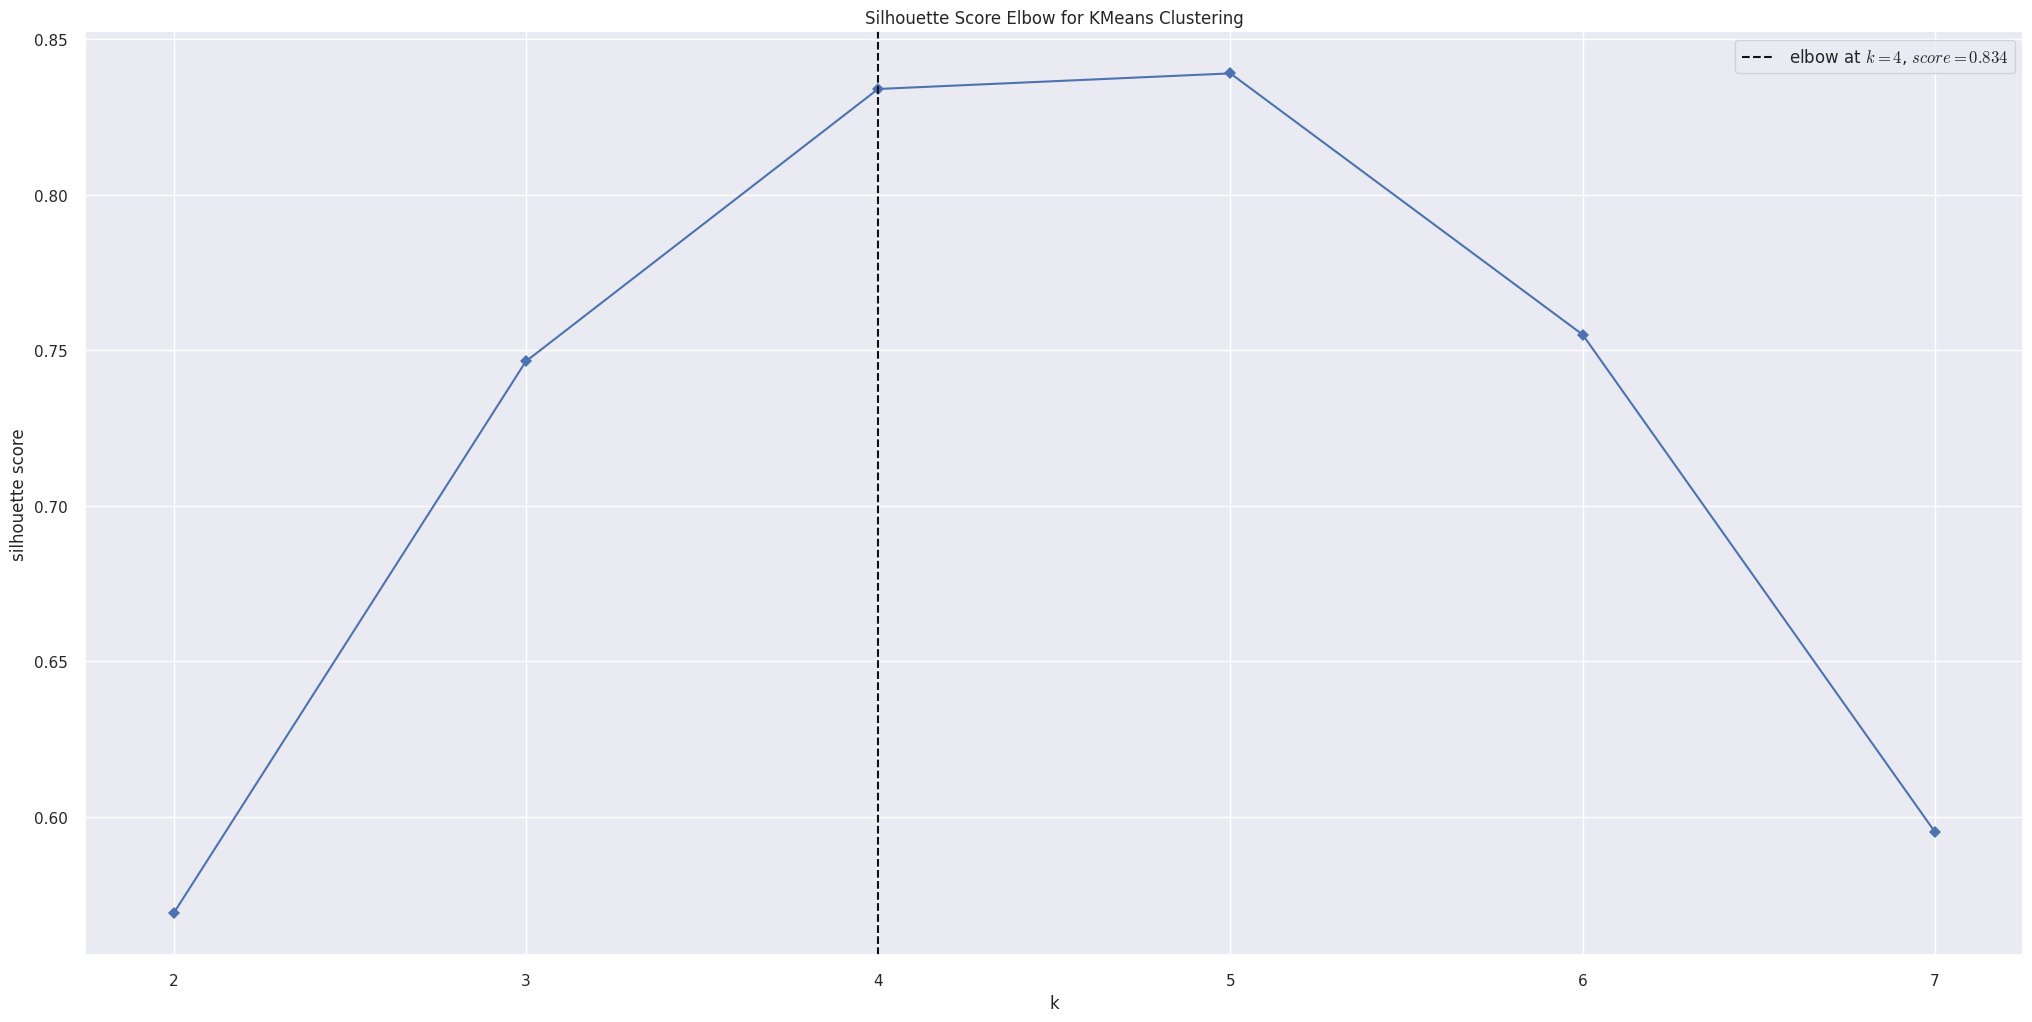

In [27]:
kmeans = KElbowVisualizer(c.KMeans(),k=clusters,metric='silhouette',timings=False)
kmeans.fit(X)
kmeans.show();

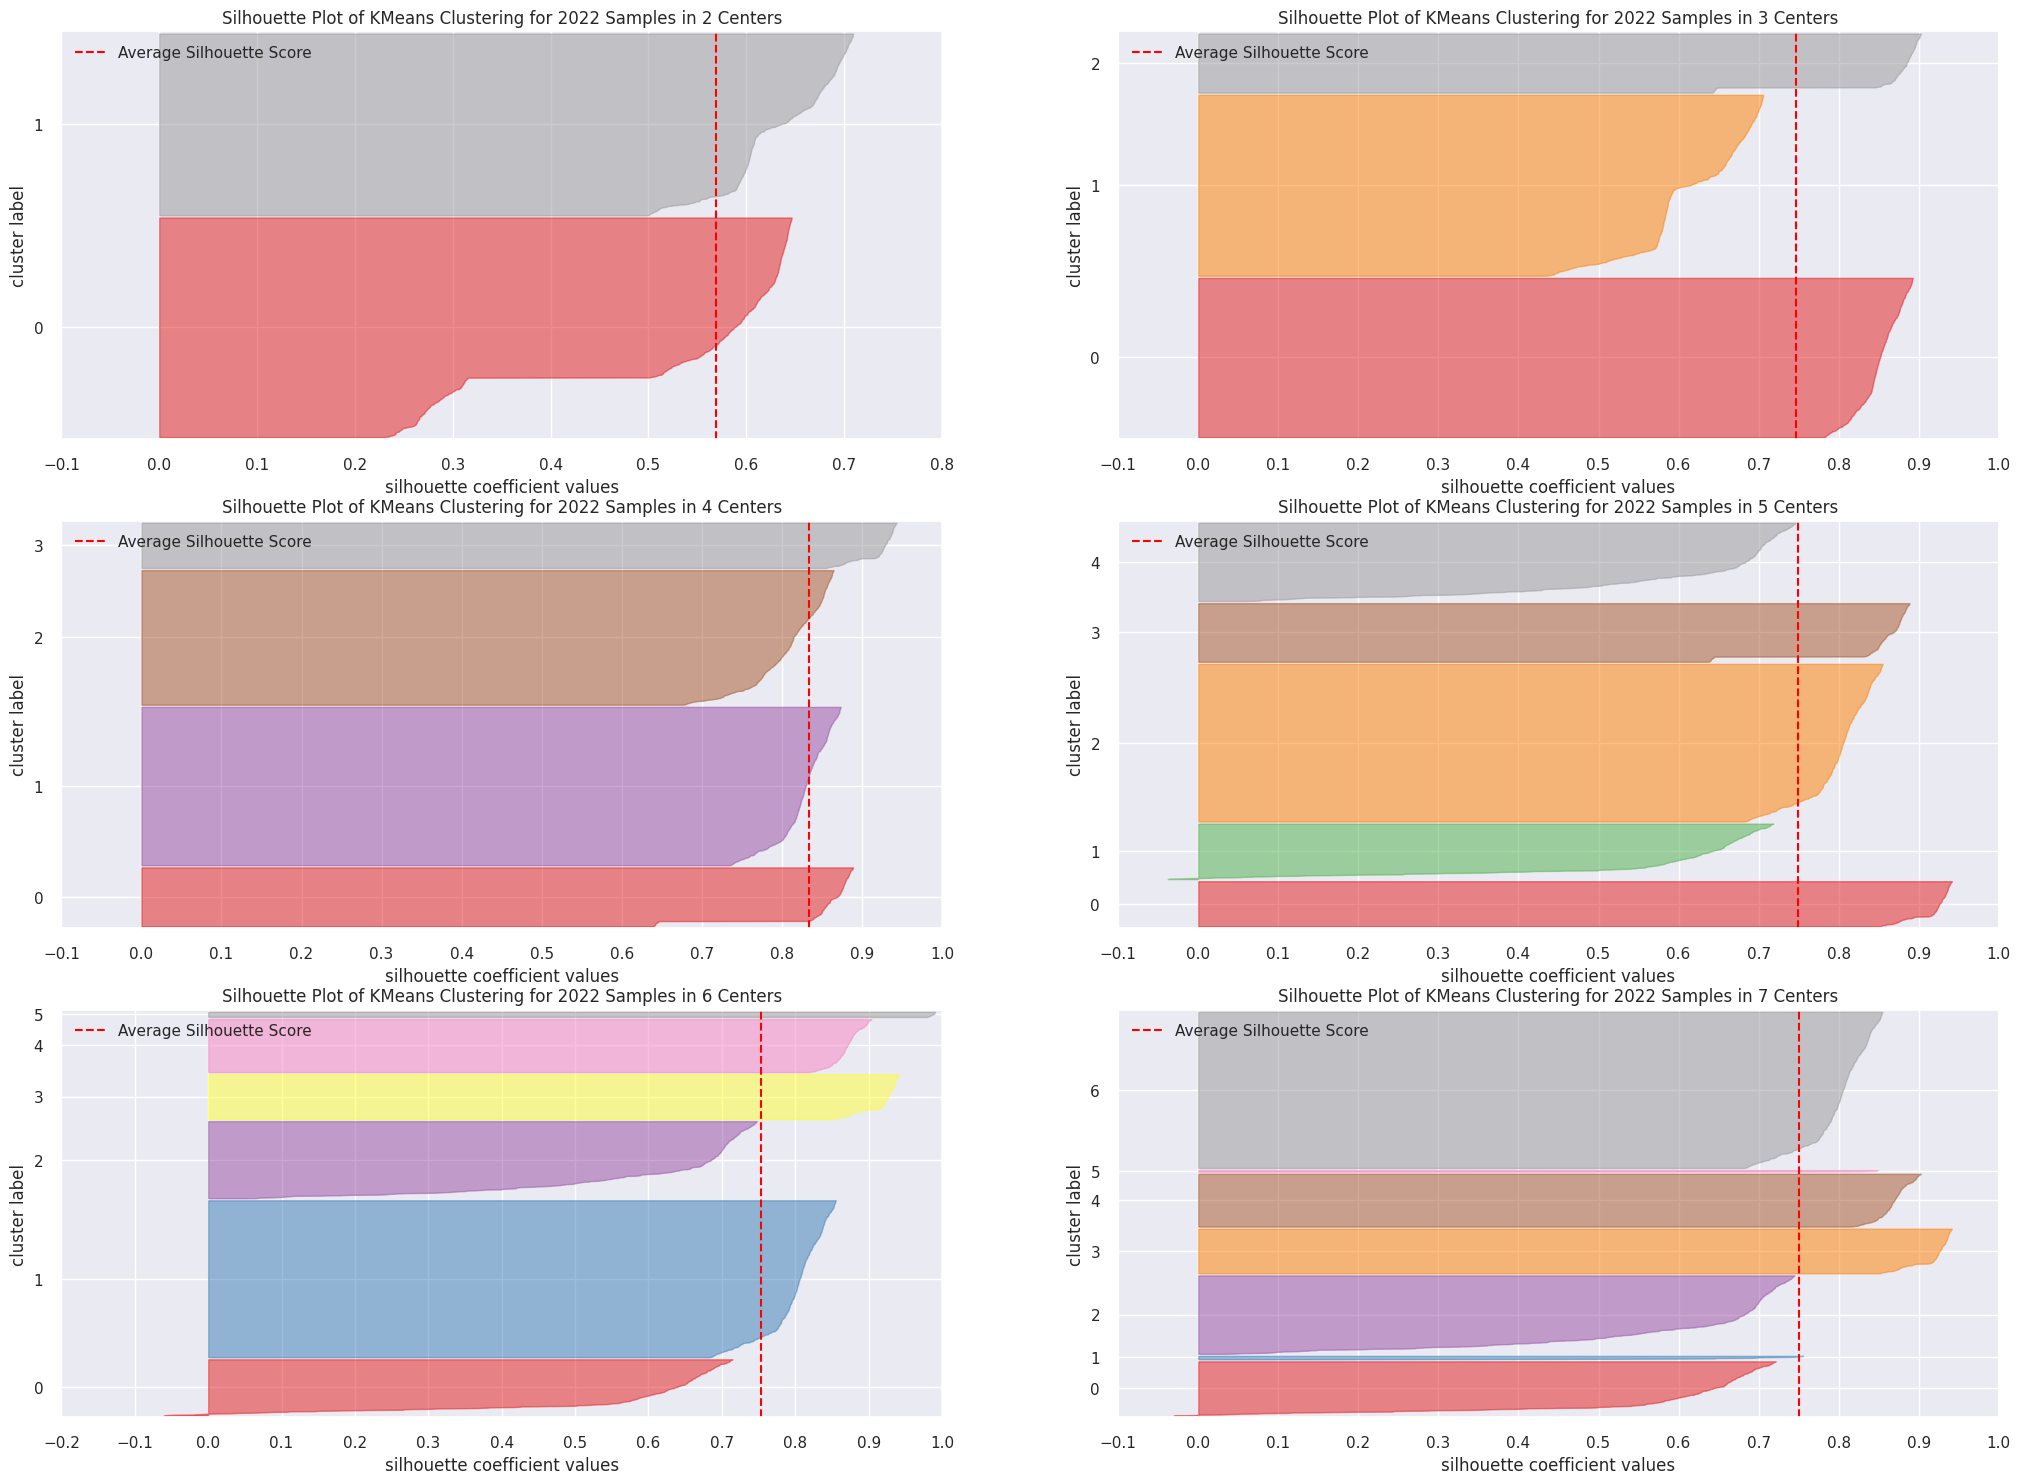

In [28]:
fig, ax = plt.subplots(3,2,figsize=(25,18))
#k=2
for k in clusters:
    km = c.KMeans(n_clusters=k,init='random',n_init=10, max_iter=100,random_state=42)
    l,i = divmod(k,2)
    visualizer = SilhouetteVisualizer(km, color='yellowbrick',ax=ax[l-1][i])
    visualizer.fit(X)
    visualizer.finalize()

## GMM

AIC - ajuste do modelo
BIC - ajuste dos parametros

In [29]:
gmm_list = []
for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture(n_components=k)

    #model training
    gmm_model.fit(X)

    #model predict
    labels = gmm_model.predict(X)

    #model performace
    gmm_list.append(sklearn.metrics.silhouette_score(X,labels,metric='euclidean'))

**Sillhouete Score**

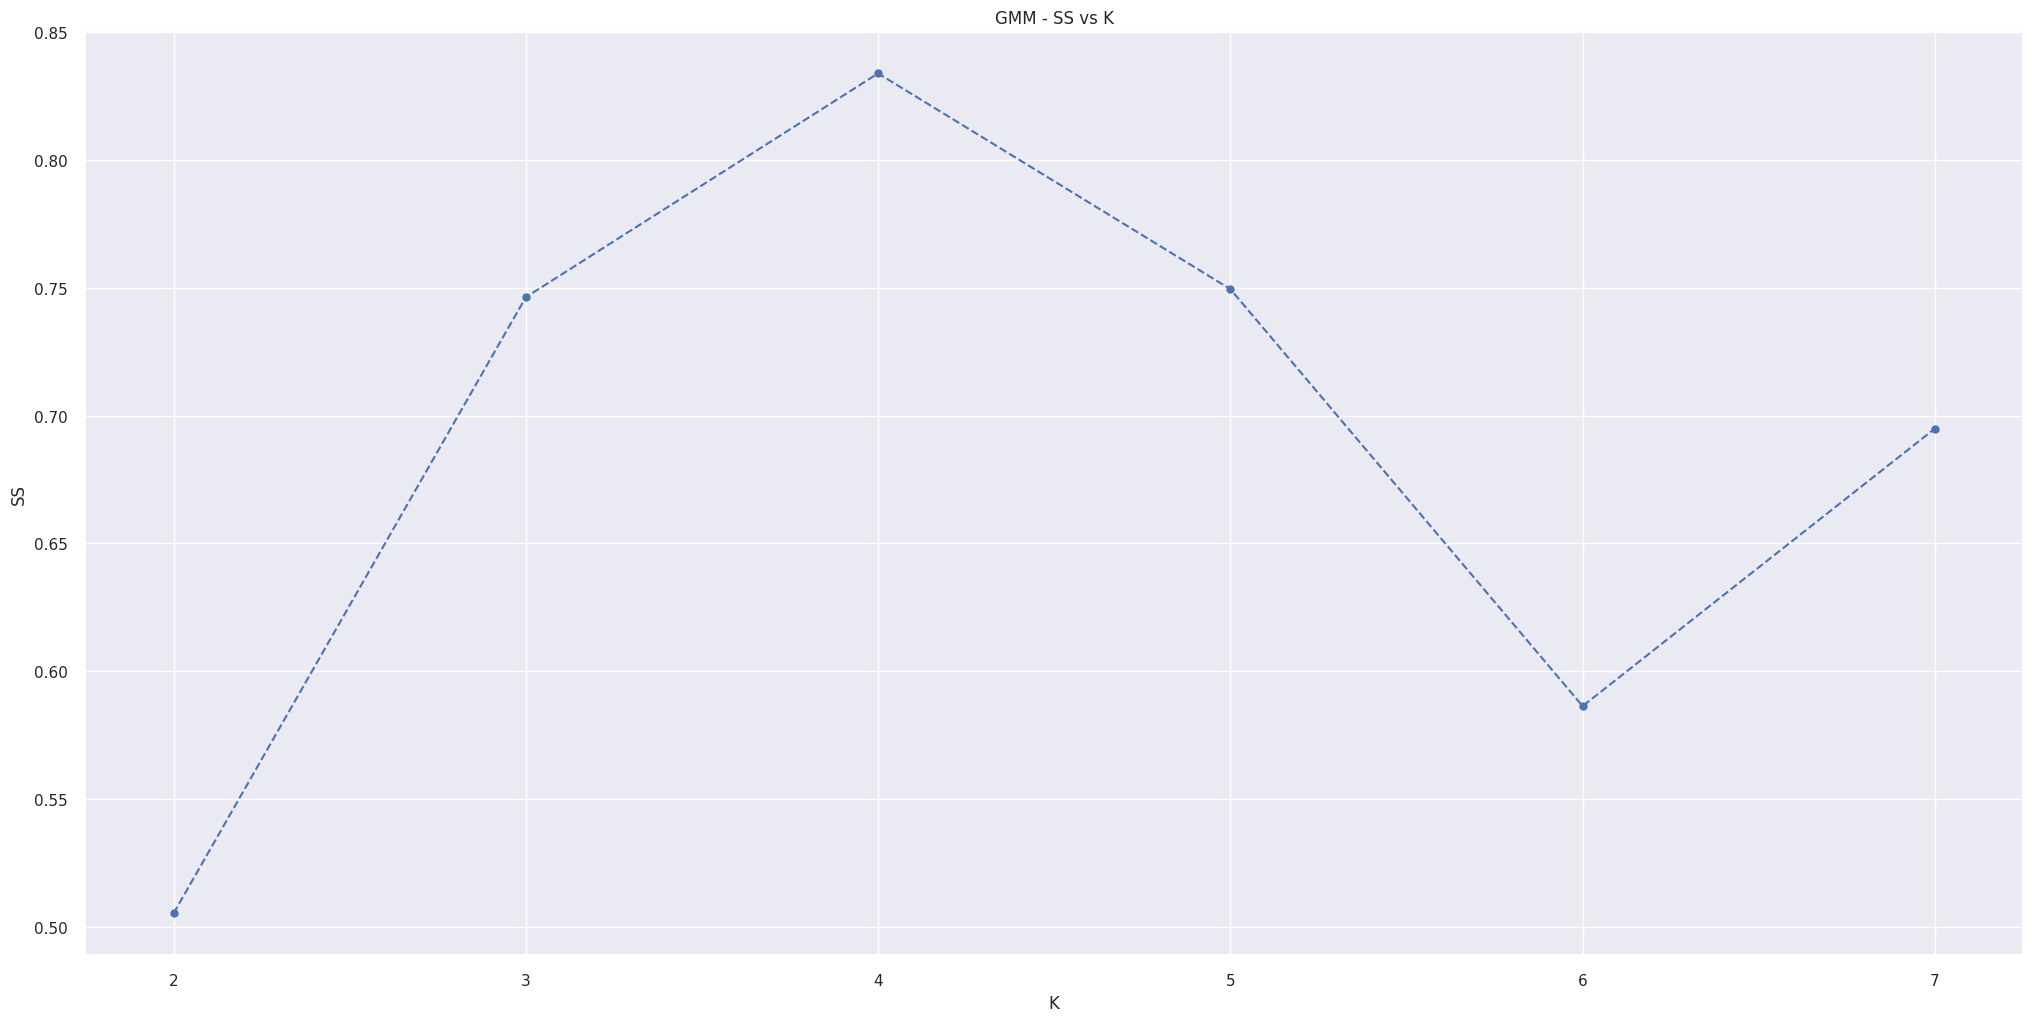

In [30]:
plt.plot(clusters,gmm_list,linestyle='--',marker = 'o');
plt.xlabel('K');
plt.ylabel('SS');
plt.title('GMM - SS vs K');

**Silhouete analisys**

For K = 2 Silhouette: 0.56114262342453
For K = 3 Silhouette: 0.7463933825492859
For K = 4 Silhouette: 0.8339849710464478
For K = 5 Silhouette: 0.8389941453933716
For K = 6 Silhouette: 0.7544093132019043
For K = 7 Silhouette: 0.6214033365249634


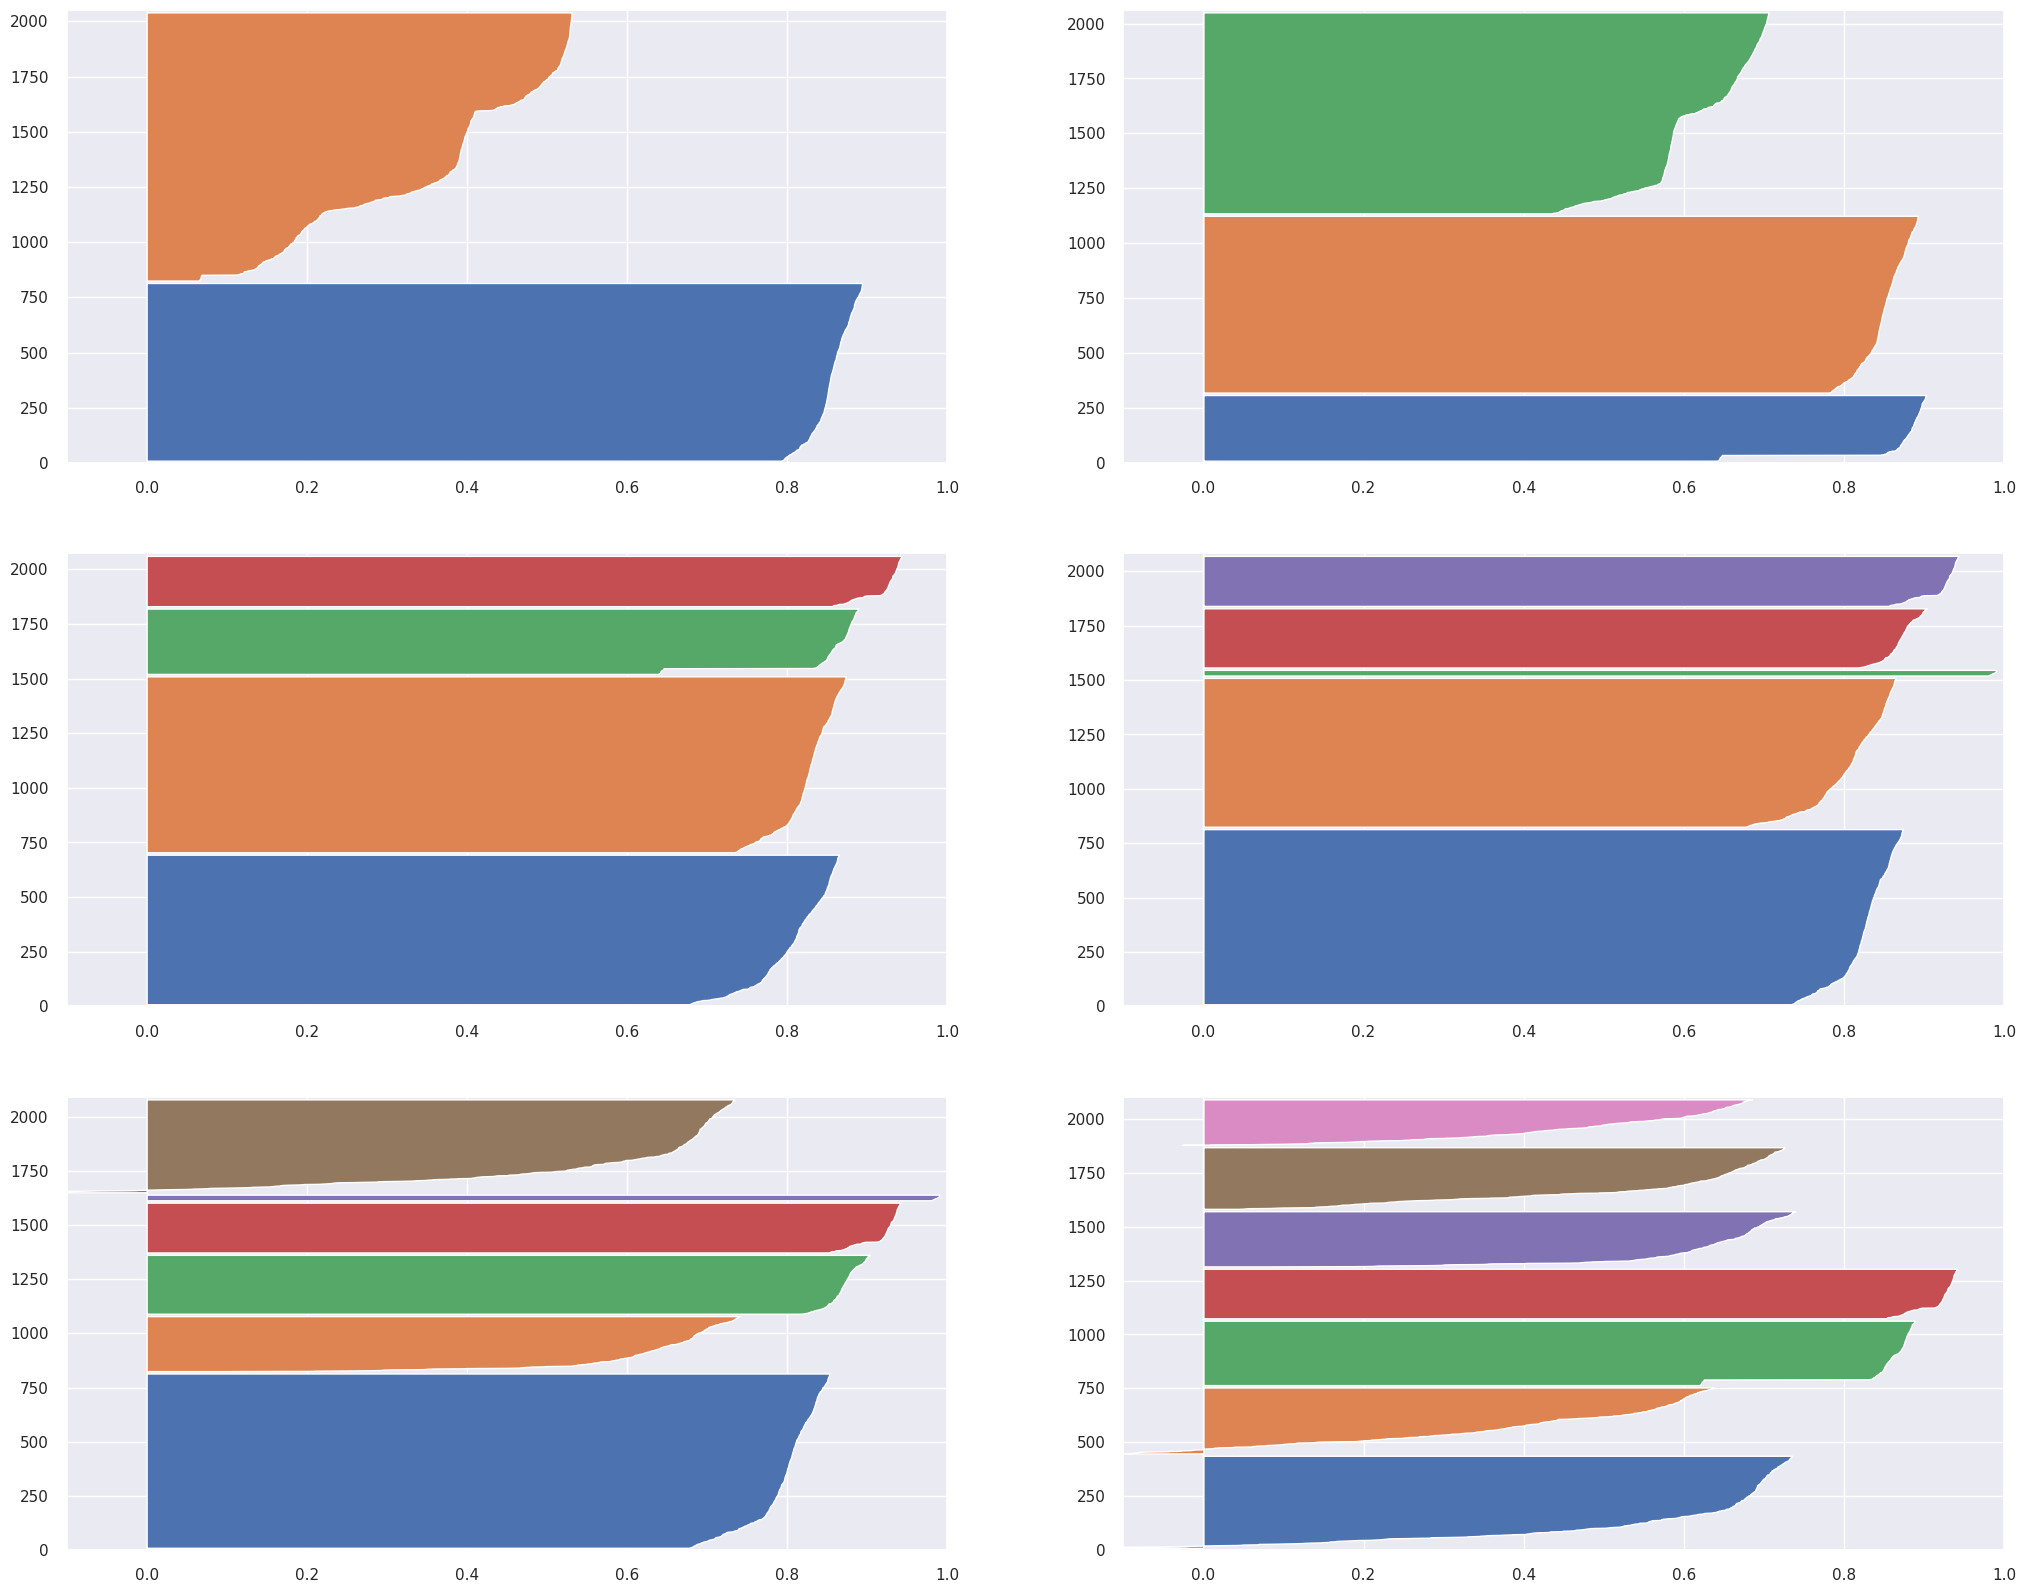

In [31]:
fig,ax = plt.subplots(3,2)
fig.set_size_inches(25,20)

for k in clusters:
    q,mod = divmod(k,2)
    
    ax[q-1,mod].set_xlim([-0.1,1])
    ax[q-1,mod].set_ylim([0,len(X) + (k+1)*10])
    # model definition
    gmm_model = mx.GaussianMixture(n_components=k)

    #model training
    gmm_model.fit(X)

    #model predict
    labels = gmm_model.predict(X)

    #model performace
    gmm_k = sklearn.metrics.silhouette_score(X,labels,metric='euclidean')
    print(f'For K = {k} Silhouette: {gmm_k}')
    
    ss_values = sklearn.metrics.silhouette_samples(X,labels)
    y_lower=10
    for i in range(k):

        ith_ss_values = ss_values[labels==i]
        size_cluster = ith_ss_values.shape[0]
        ith_ss_values = np.sort(ith_ss_values)
        y_upper = y_lower + size_cluster
        ax[q-1,mod].fill_betweenx(np.arange(y_lower,y_upper),0,ith_ss_values)
        y_lower = y_upper+10

## H-Clustering

In [32]:
hc_model = hr.linkage(X,'ward')

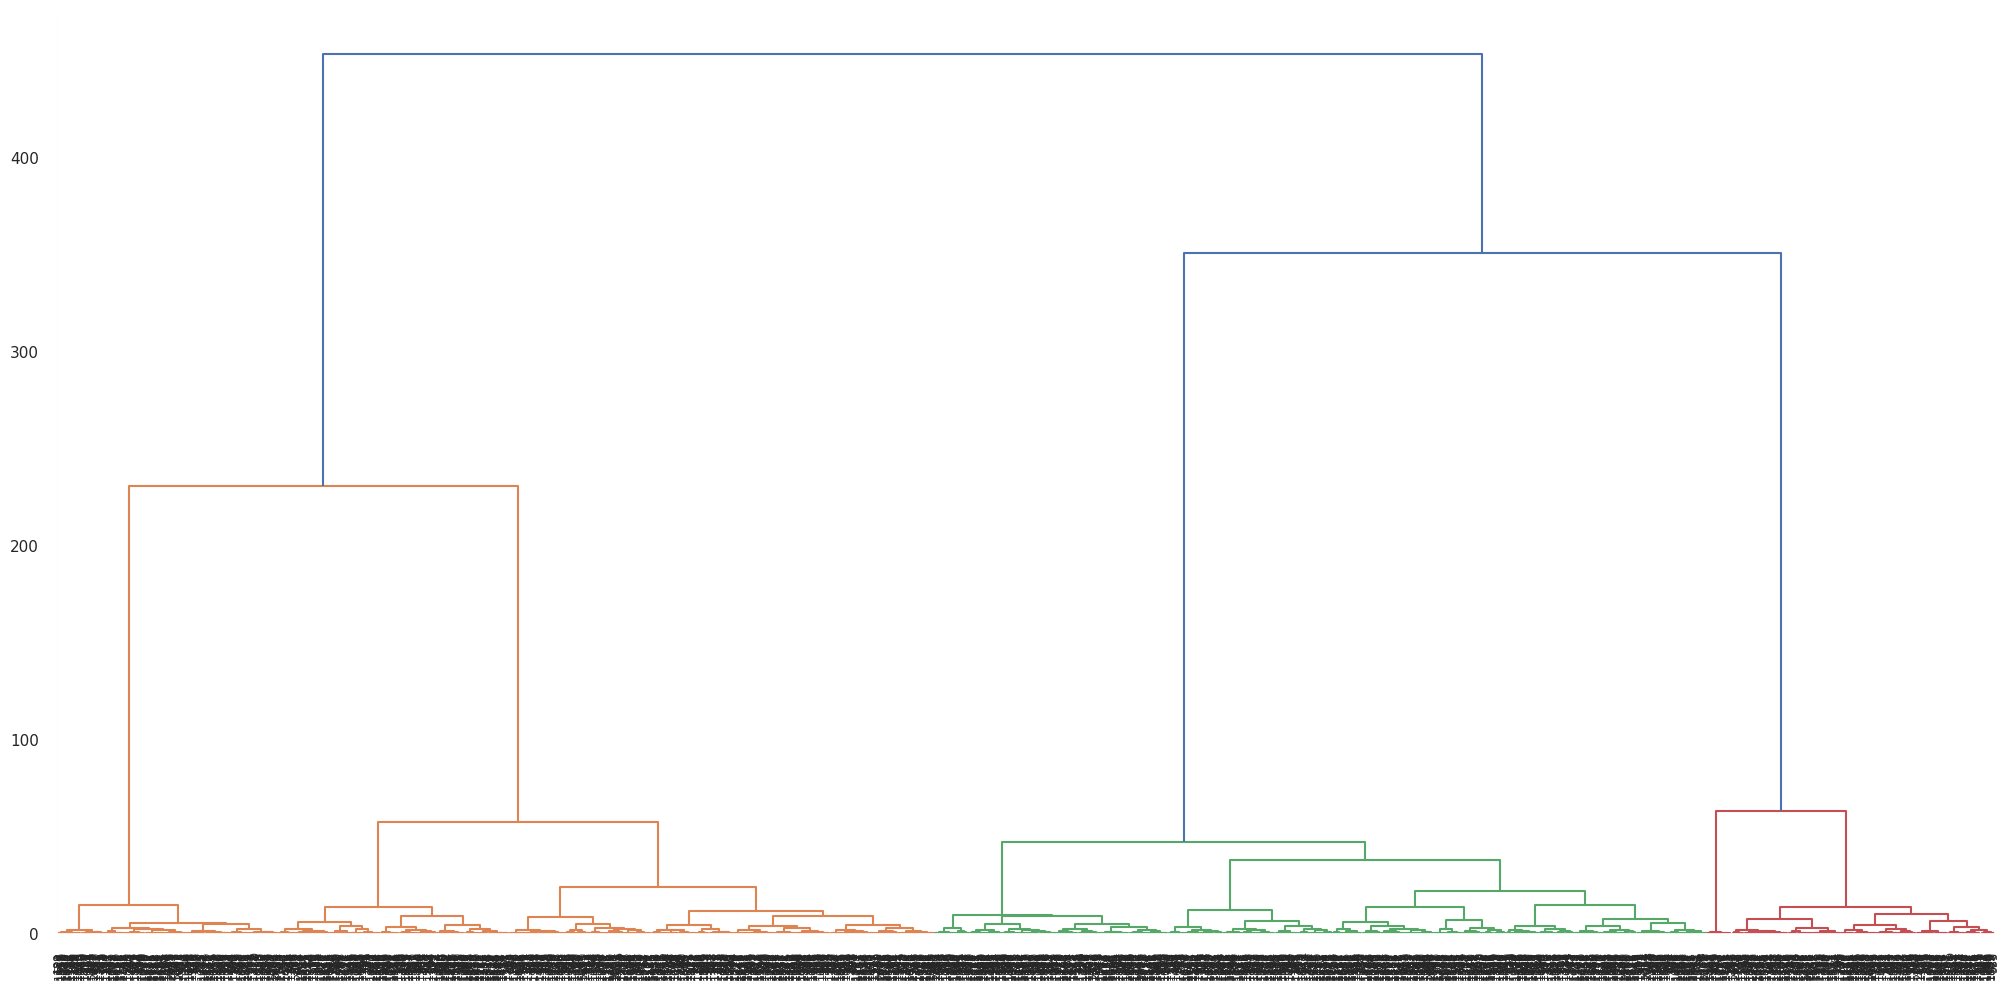

In [33]:
hr.dendrogram(hc_model,
             leaf_rotation=90,
             leaf_font_size=8)
plt.plot();

In [34]:
hc_list = []
for k in clusters:
    # model definition
    hc_model = hr.linkage(X,'ward')

    #model predict
    labels = hr.fcluster(hc_model,k,criterion='maxclust')

    #model performace
    hc_list.append(sklearn.metrics.silhouette_score(X,labels,metric='euclidean'))

**Sillhouete Score**

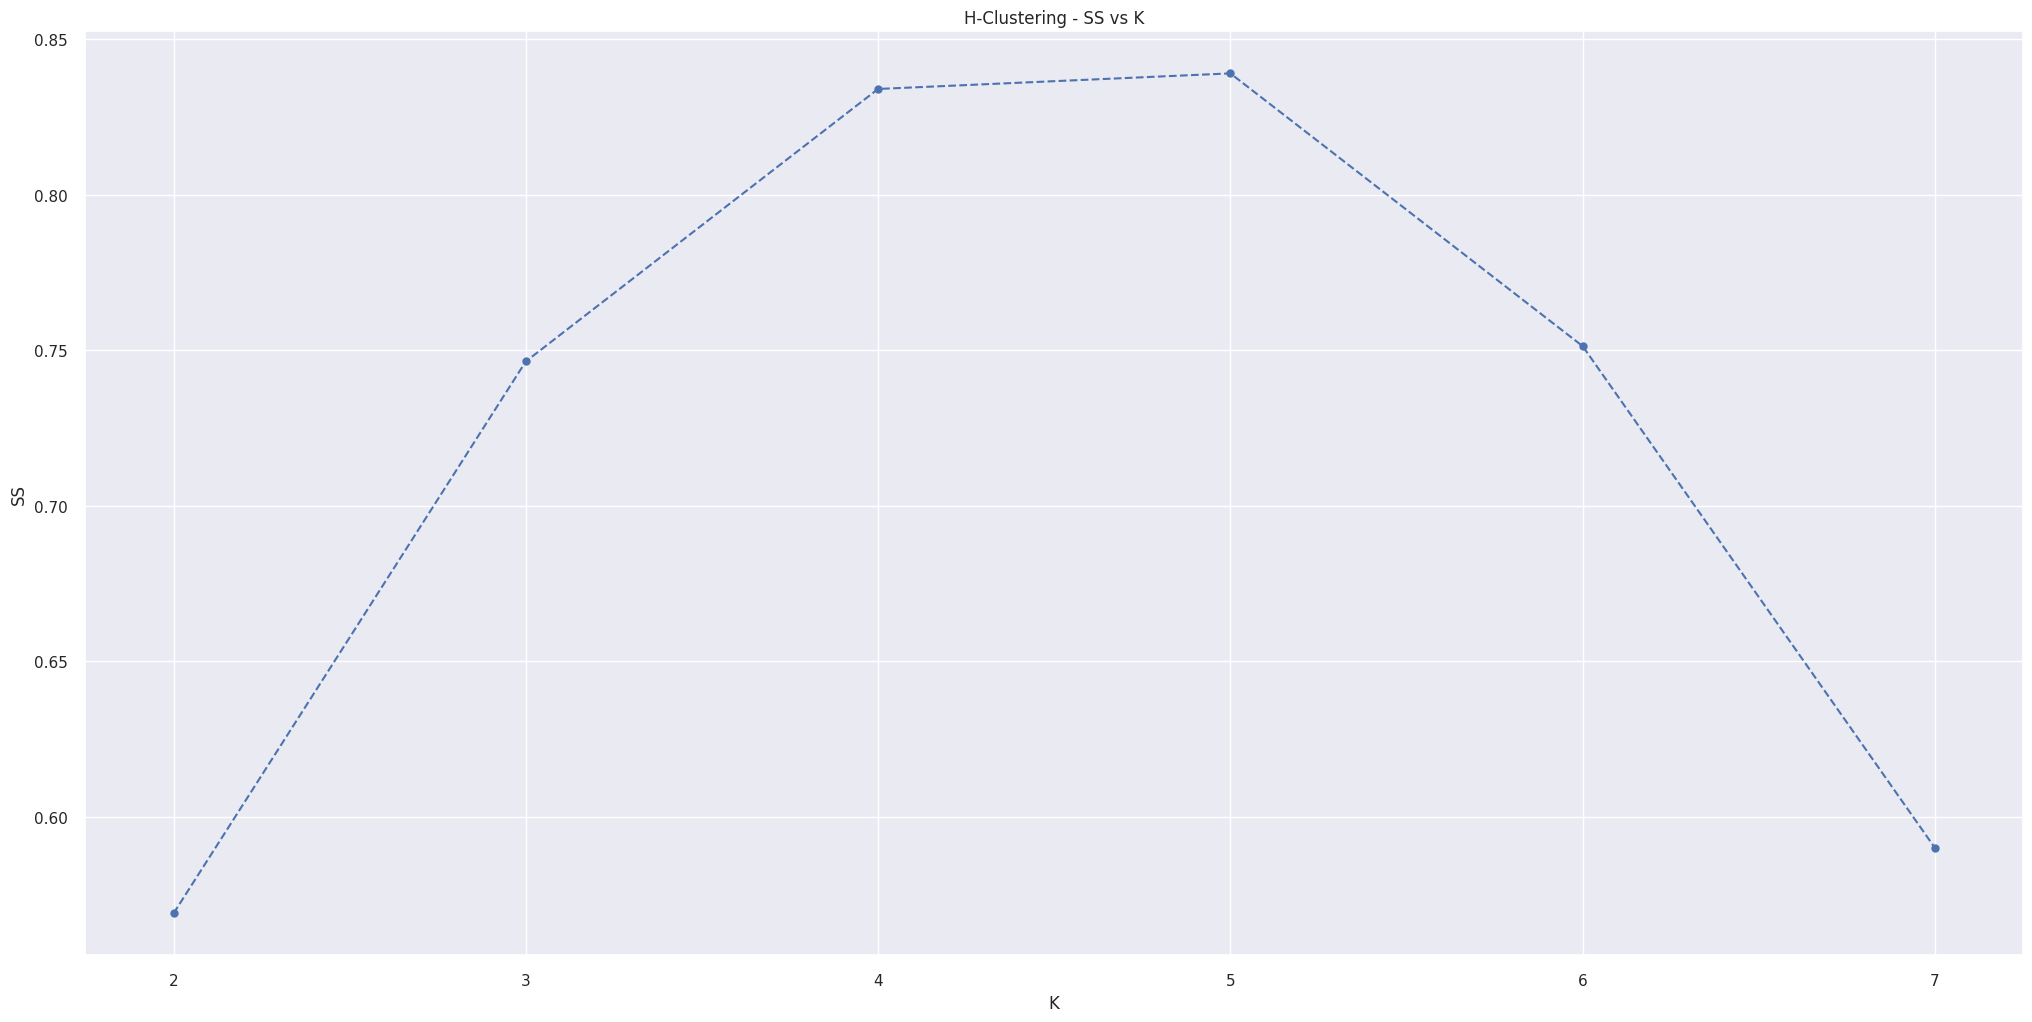

In [35]:
plt.plot(clusters,hc_list,linestyle='--',marker = 'o');
plt.xlabel('K');
plt.ylabel('SS');
plt.title('H-Clustering - SS vs K');

**Silhouete analisys**

For K = 2 Silhouette: 0.5689308643341064
For K = 3 Silhouette: 0.7463933825492859
For K = 4 Silhouette: 0.8339849710464478
For K = 5 Silhouette: 0.8389941453933716
For K = 6 Silhouette: 0.7513046860694885
For K = 7 Silhouette: 0.5899850130081177


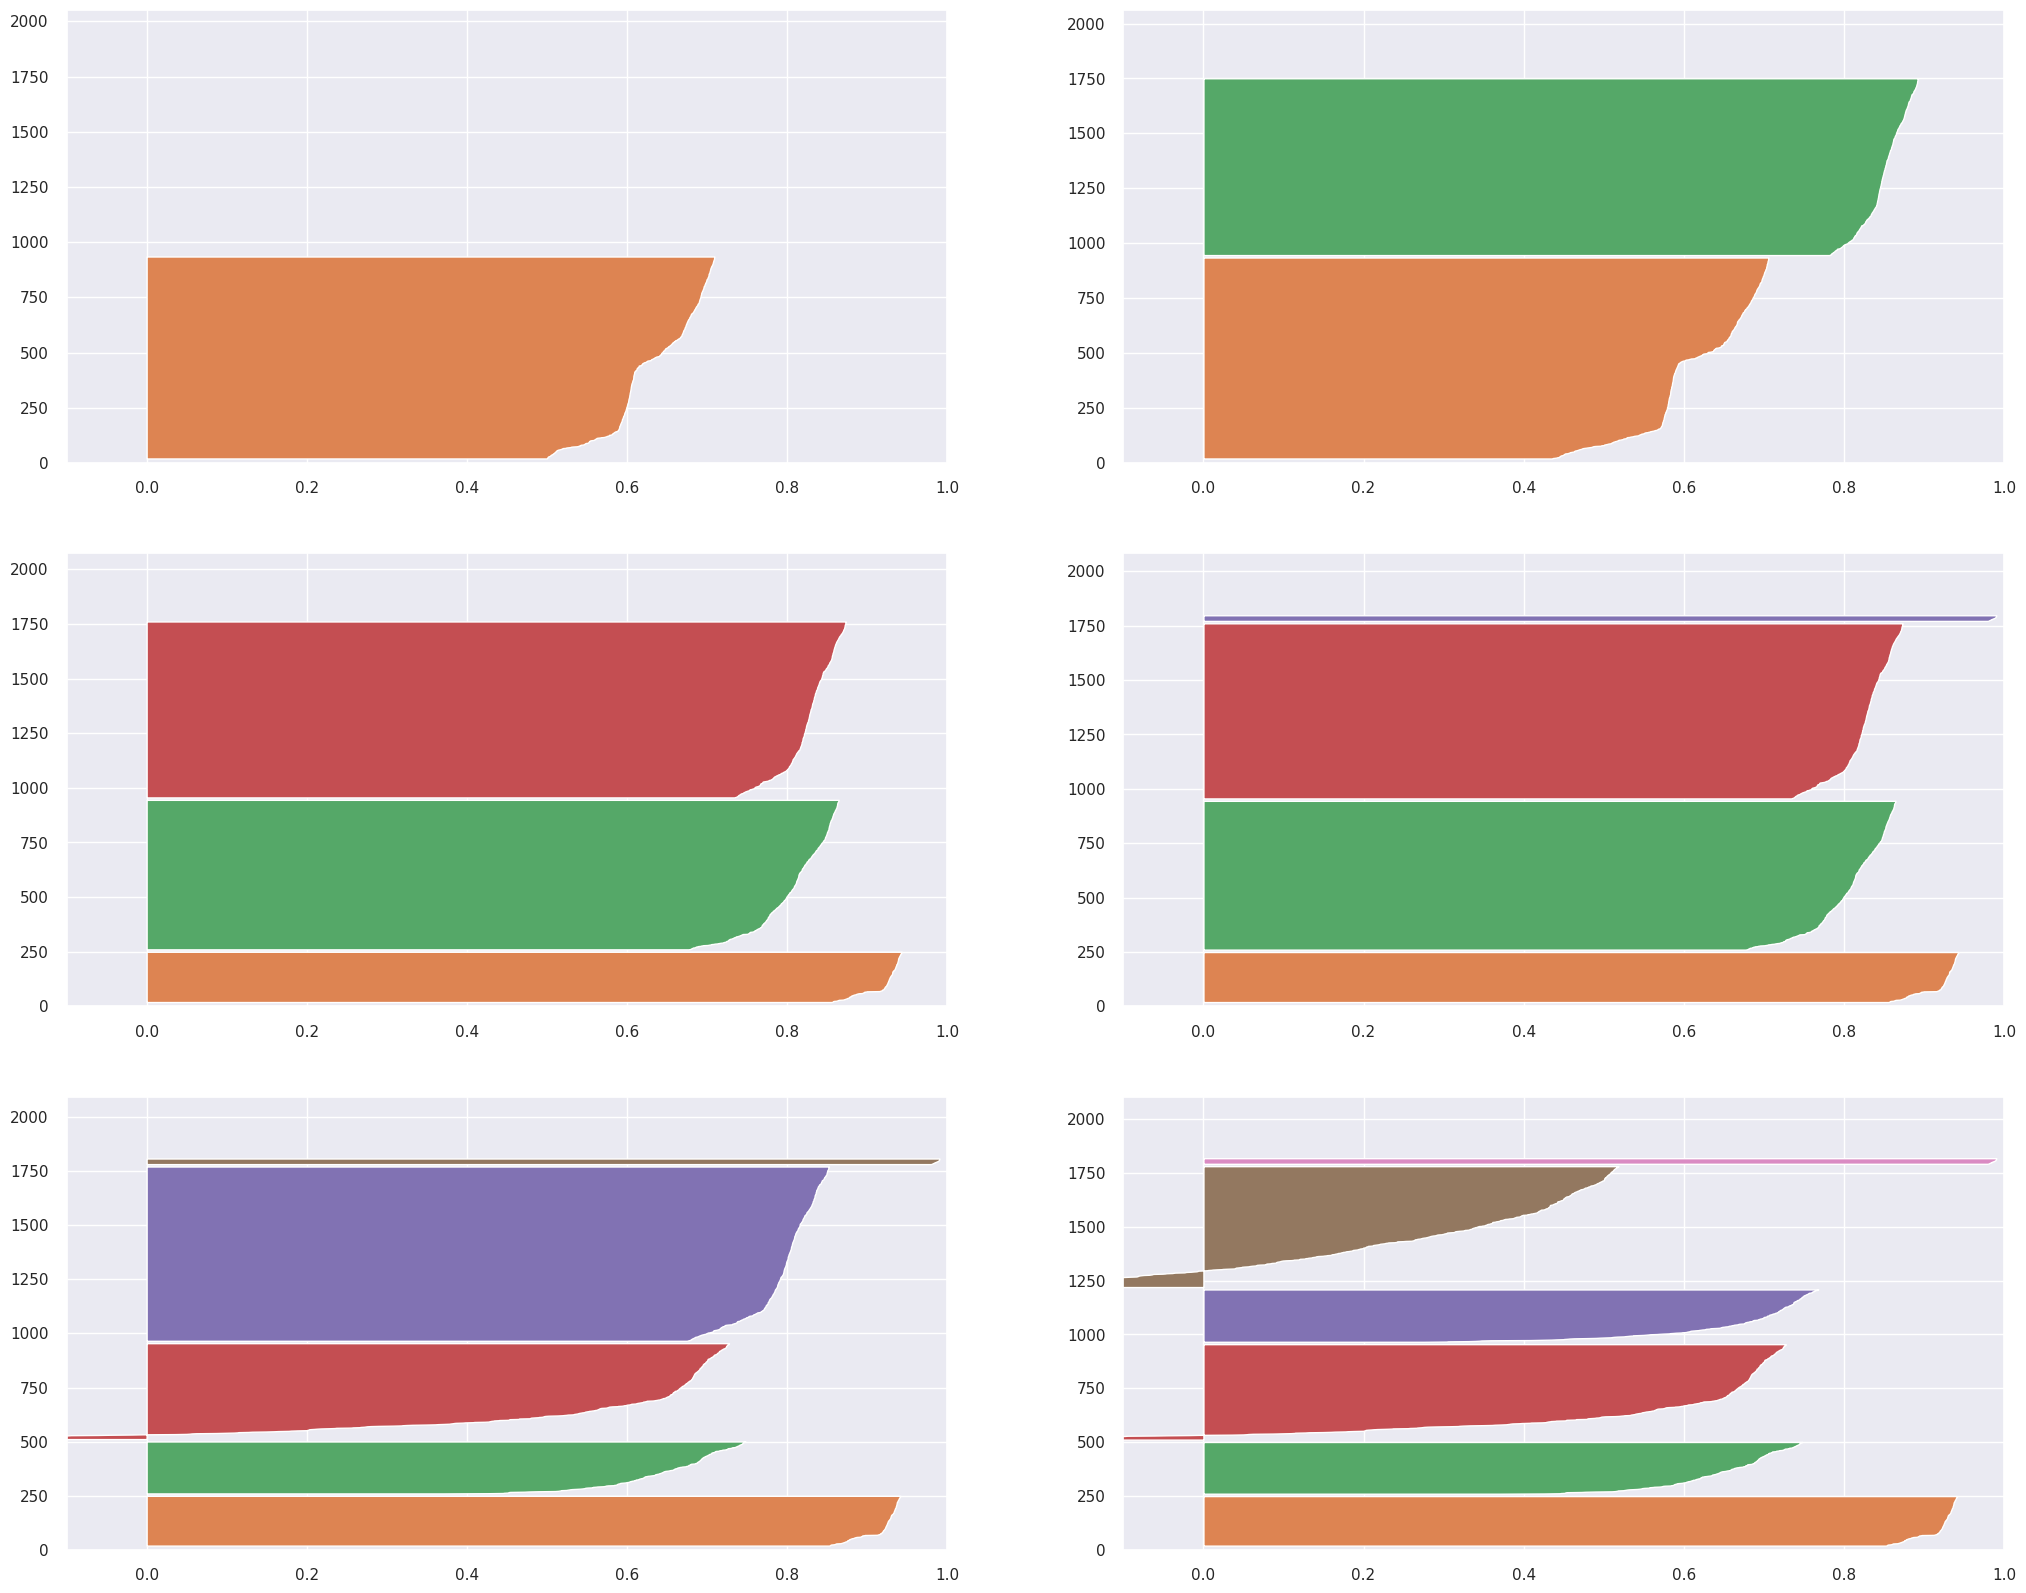

In [36]:
fig,ax = plt.subplots(3,2)
fig.set_size_inches(25,20)

for k in clusters:
    q,mod = divmod(k,2)
    
    ax[q-1,mod].set_xlim([-0.1,1])
    ax[q-1,mod].set_ylim([0,len(X) + (k+1)*10])
    # model definition    
    hc_model = hr.linkage(X,'ward')

    #model predict    
    labels = hr.fcluster(hc_model,k,criterion='maxclust')

    #model performace    
    hc_k = (sklearn.metrics.silhouette_score(X,labels,metric='euclidean'))
    print(f'For K = {k} Silhouette: {hc_k}')
    
    ss_values = sklearn.metrics.silhouette_samples(X,labels)
    y_lower=10
    for i in range(k):

        ith_ss_values = ss_values[labels==i]
        size_cluster = ith_ss_values.shape[0]
        ith_ss_values = np.sort(ith_ss_values)
        y_upper = y_lower + size_cluster
        ax[q-1,mod].fill_betweenx(np.arange(y_lower,y_upper),0,ith_ss_values)
        y_lower = y_upper+10

## Results

In [37]:
# Model name | k=2 | k=3 | k=4 | k=5
# Kmeans        ss    ss    ss    ss
# GMM           ss    ss    ss    ss
# HC            ss    ss    ss    ss
# DBSCAN        ss    ss    ss    ss

df_results = pd.DataFrame({
    'Kmeans': sil_k,
    'GMM': gmm_list,
    'HC': hc_list,
}).T
df_results.columns = clusters
df_results.style.highlight_max(color='lightgreen',axis=1)

,2,3,4,5,6,7
Kmeans,0.568931,0.746393,0.833985,0.838994,0.755005,0.595132
GMM,0.505220,0.746393,0.833985,0.749554,0.586351,0.694969
HC,0.568931,0.746393,0.833985,0.838994,0.751305,0.589985


# Model training

In [38]:
#model training
k = 5
kmeans = c.KMeans(n_clusters=k,random_state=42)
#model training
kmeans.fit(X)
#clustering
labels = kmeans.labels_

### Cluster validation

In [39]:
# WSS
print('WSS value',kmeans.inertia_)

## SS (Silhouette Score)
print('SS value',sklearn.metrics.silhouette_score(X,labels,metric='euclidean'))

WSS value 5462.234375
SS value 0.83899415


### Cluster analysis

In [40]:
df9 = df8.copy()
df9['clusters'] = labels

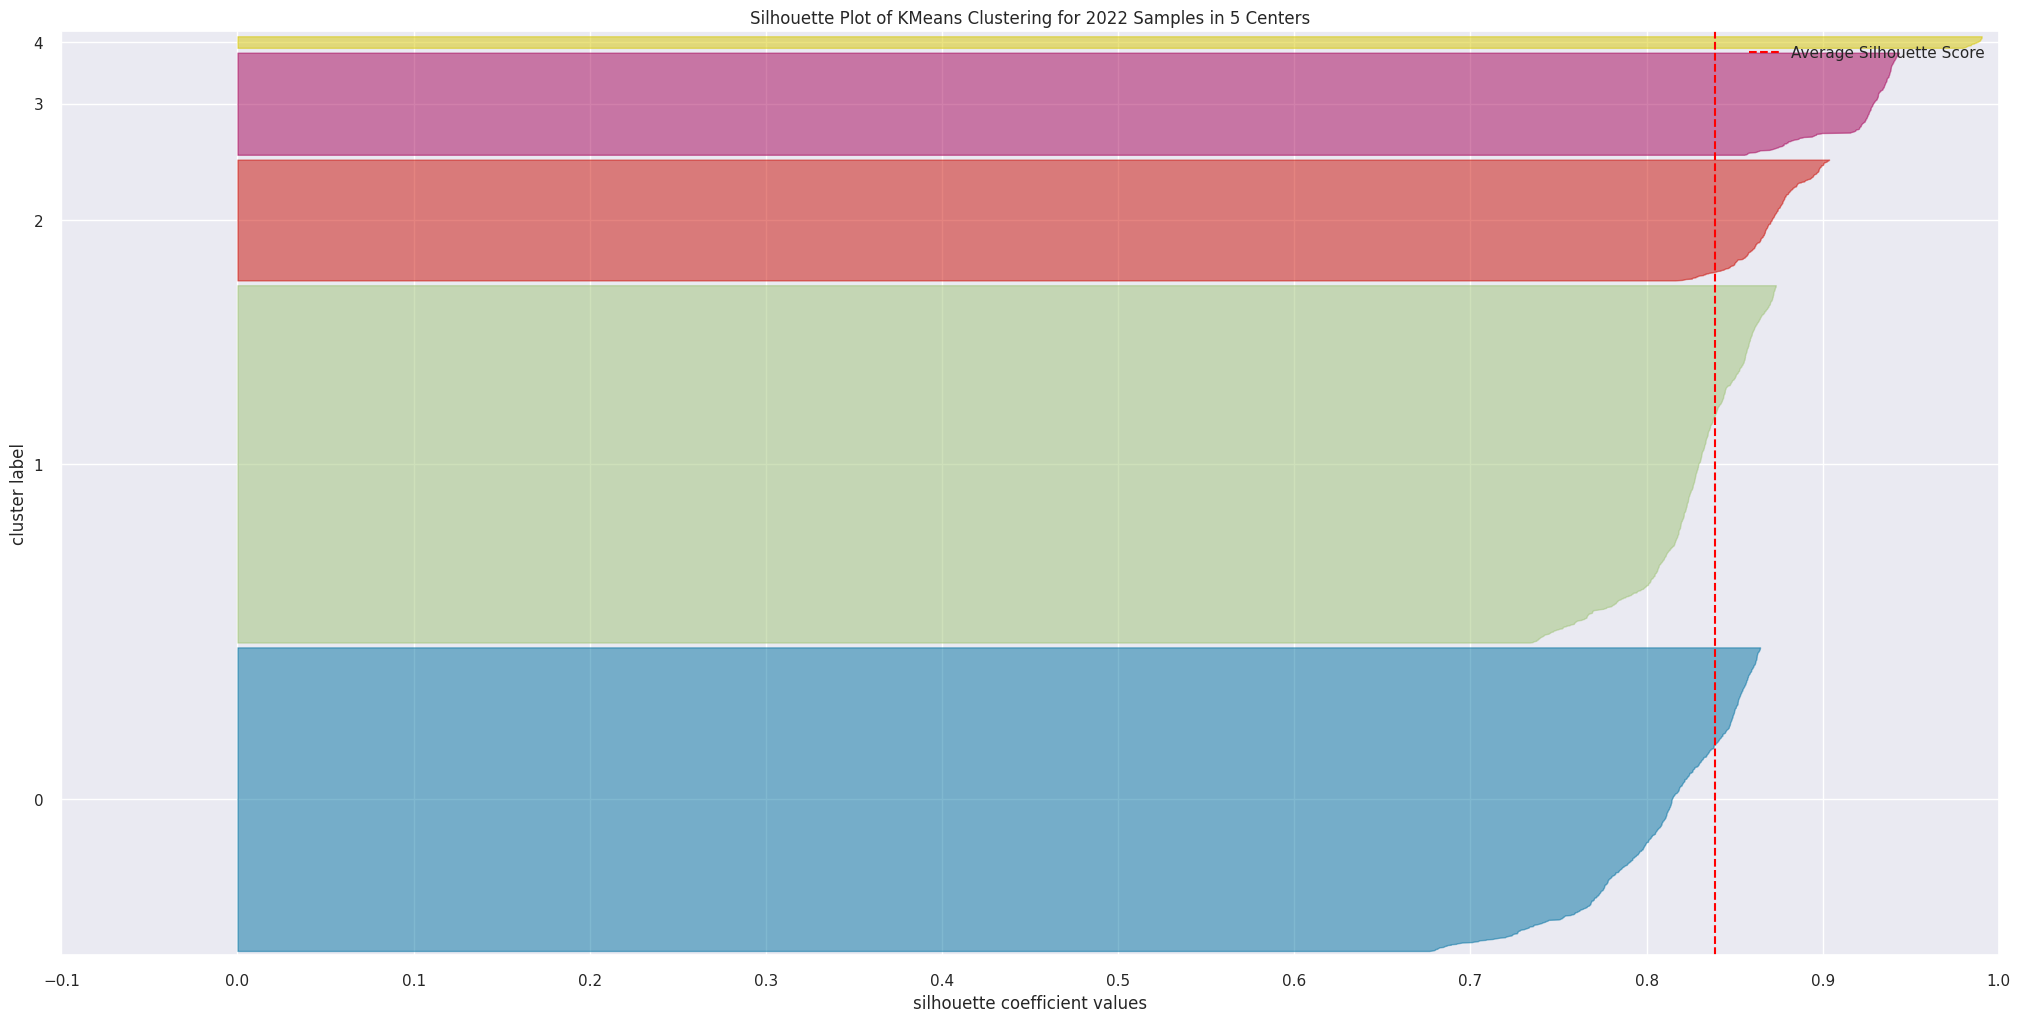

In [41]:
visualizer = SilhouetteVisualizer(kmeans,colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

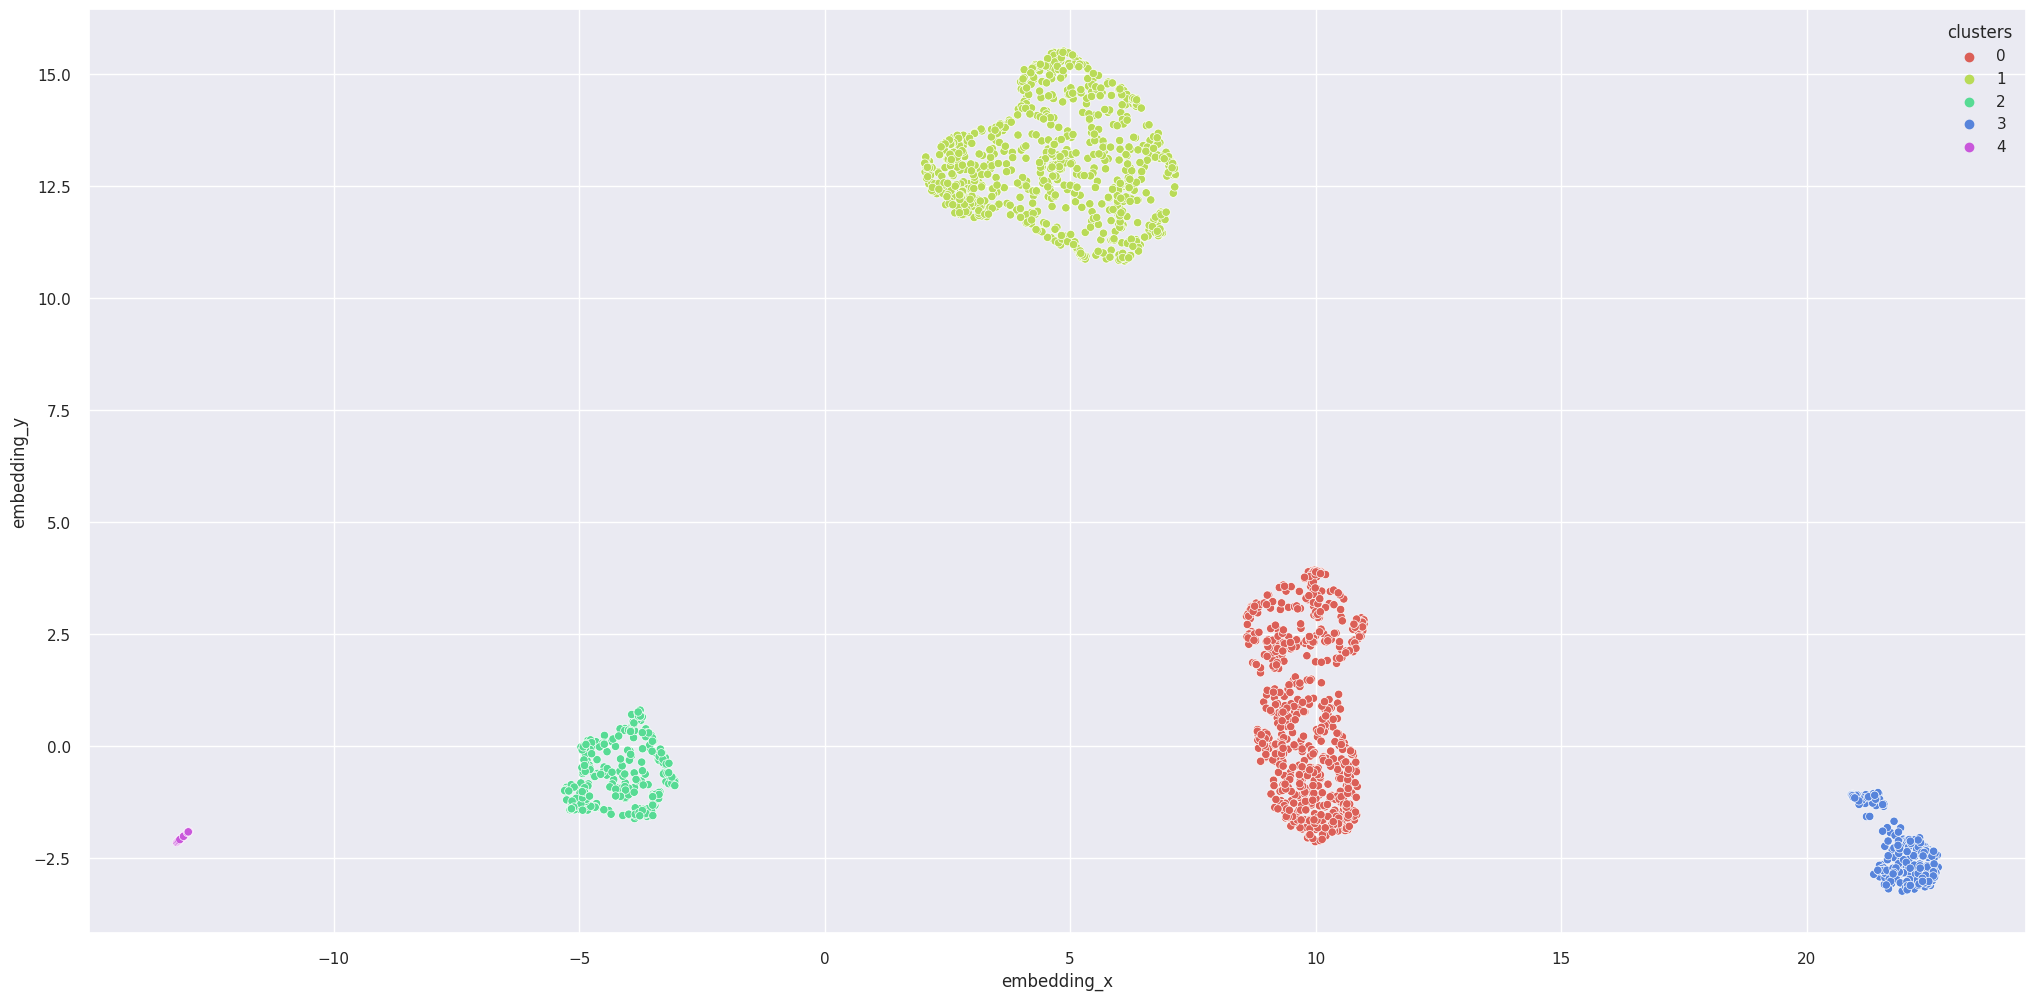

In [42]:
# reducer = umap.UMAP(n_neighbors=100,random_state=42)
# embedding = reducer.fit_transform(X)

df_viz = X.copy()
df_viz['clusters'] = labels
# df_viz['embedding_x'] = embedding[:,0]
# df_viz['embedding_y'] = embedding[:,1]

sns.scatterplot(x='embedding_x',y='embedding_y',hue='clusters', palette=sns.color_palette('hls',n_colors=len(df_viz['clusters'].unique())),data = df_viz)

# Cluster profile

In [43]:
df10 = pd.read_csv(path_local+'src/data/df_prep.csv')
df10 = df10[cols_selected]
df10['clusters'] = labels

In [44]:
# number of customers
df_cluster = df10[['id','clusters']].groupby('clusters').count().reset_index()
df_cluster['perc_customer_%'] = np.round_((df_cluster['id']/df_cluster['id'].sum())*100,2)

# Loop para iterar sobre as variáveis
for var in ['income','recency', 'mnt_wines', 'mnt_fruits','mnt_meat_products', 'mnt_fish_products', 'mnt_sweet_products','mnt_gold_prods', 'num_deals_purchases', 'num_web_purchases',            'num_catalog_purchases', 'num_store_purchases', 'num_web_visits_month','age', 'n_family_members', 'days_since_signup', 'income_per_member','total_spent']:
    
    df_avg_var = df10[[var,'clusters']].groupby('clusters').mean().reset_index()
    df_cluster = pd.merge(df_cluster, df_avg_var, how='inner', on='clusters')


In [45]:
pd.set_option('display.max_columns', None)
df_cluster.sort_values(by='total_spent',ascending=False)

,clusters,id,perc_customer_%,income,recency,mnt_wines,mnt_fruits,mnt_meat_products,mnt_fish_products,mnt_sweet_products,mnt_gold_prods,num_deals_purchases,num_web_purchases,num_catalog_purchases,num_store_purchases,num_web_visits_month,age,n_family_members,days_since_signup,income_per_member,total_spent
3,3,231,11.42,65577.948052,50.562771,495.454545,51.670996,372.125541,71.961039,54.043290,64.588745,1.203463,4.493506,4.575758,7.350649,3.731602,51.008658,1.0,347.043290,65577.948052,1109.844156
0,0,685,33.88,56110.162044,47.483212,377.461314,36.284672,230.265693,52.740146,36.451095,50.972263,1.807299,4.356204,3.443796,6.381022,4.702190,50.864234,2.0,363.744526,28055.081022,784.175182
1,1,806,39.86,46808.433002,48.642680,248.595533,17.374690,91.727047,24.418114,18.750620,39.367246,2.594293,4.140199,1.934243,5.384615,5.959057,50.105459,3.0,350.447891,15602.811001,440.233251
4,4,27,1.34,47058.555556,55.740741,198.925926,7.000000,65.296296,7.037037,4.333333,19.888889,3.629630,2.888889,1.000000,3.703704,6.000000,56.074074,5.0,324.592593,9411.711111,302.481481
2,2,273,13.50,45228.384615,51.157509,145.673993,7.827839,50.809524,10.934066,8.714286,22.871795,3.604396,3.186813,1.095238,4.450549,6.377289,54.384615,4.0,335.032967,11307.096154,246.831502


In [54]:
df_show = df_cluster[["clusters","id","perc_customer_%","income","total_spent"]].sort_values(by='total_spent',ascending=False)

# transform income and total_spend in monetary values
df_show["total_spent"] = df_show["total_spent"].apply(lambda x: f'R$ {x:,.2f}')
df_show["income"] = df_show["income"].apply(lambda x: f'R$ {x:,.2f}')

# rename "id" column to "quantity_customers"
df_show.rename(columns={"id":"quantity_customers","total_spent":"mean_total_spent","income":"anual_income"},inplace=True)
df_show.reset_index(drop=True,inplace=True)
df_show

,clusters,quantity_customers,perc_customer_%,anual_income,mean_total_spent
0,3,231,11.42,"R$ 65,577.95","R$ 1,109.84"
1,0,685,33.88,"R$ 56,110.16",R$ 784.18
2,1,806,39.86,"R$ 46,808.43",R$ 440.23
3,4,27,1.34,"R$ 47,058.56",R$ 302.48
4,2,273,13.50,"R$ 45,228.38",R$ 246.83


3 - Buyers

0 - olders

1 - army

4 - Smallville

2 - great family

# cluster analisys 

In [56]:
df11 = df10.copy()

In [57]:
names = {3:'buyers',
         0:'olders',
         1:'army',
         4:'smallville',
         2:'great_family'}

In [58]:
df11['clusters'] = df11['clusters'].map(names)

In [61]:
df11.head(5)

,id,income,recency,mnt_wines,mnt_fruits,mnt_meat_products,mnt_fish_products,mnt_sweet_products,mnt_gold_prods,num_deals_purchases,num_web_purchases,num_catalog_purchases,num_store_purchases,num_web_visits_month,age,n_family_members,days_since_signup,income_per_member,total_spent,clusters
0,5524,58138.0,58,635,88,546,172,88,88,3,8,10,4,7,63,1,663,58138.0,1617,buyers
1,2174,46344.0,38,11,1,6,2,1,6,2,1,1,2,5,66,3,113,15448.0,27,army
2,4141,71613.0,26,426,49,127,111,21,42,1,8,2,10,4,55,2,312,35806.5,776,olders
3,6182,26646.0,26,11,4,20,10,3,5,2,2,0,4,6,36,3,139,8882.0,53,army
4,5324,58293.0,94,173,43,118,46,27,15,5,5,3,6,5,39,3,161,19431.0,422,army


## EDA II 

In [63]:
# divisão dos dados em dois dataframes, um categórico e outro numérico
df11[df11['clusters']=='buyers'].drop(columns="clusters").agg(['min','max','mean','median','std','skew','kurtosis']).T

,min,max,mean,median,std,skew,kurtosis
id,1.0,11191.0,5565.194805,5350.0,3237.304093,0.050158,-1.146935
income,1730.0,153924.0,65577.948052,72217.0,23708.630330,-0.644911,0.547828
recency,0.0,99.0,50.562771,53.0,29.157357,-0.118729,-1.233574
mnt_wines,0.0,1462.0,495.454545,464.0,371.899667,0.428408,-0.762509
mnt_fruits,0.0,194.0,51.670996,33.0,49.656078,1.090046,0.197045
mnt_meat_products,0.0,984.0,372.125541,351.0,282.894690,0.406456,-0.901388
mnt_fish_products,0.0,250.0,71.961039,55.0,64.608542,0.864054,-0.286078
mnt_sweet_products,0.0,262.0,54.043290,38.0,52.255208,1.143666,0.828124
mnt_gold_prods,0.0,262.0,64.588745,43.0,59.164837,1.268031,1.006501
num_deals_purchases,0.0,15.0,1.203463,1.0,1.404089,8.369242,80.319687


In [64]:
# divisão dos dados em dois dataframes, um categórico e outro numérico
df11[df11['clusters']=='olders'].drop(columns="clusters").agg(['min','max','mean','median','std','skew','kurtosis']).T

,min,max,mean,median,std,skew,kurtosis
id,0.0,11187.0,5600.381022,5371.0,3309.255363,0.053153,-1.244795
income,3502.0,156924.0,56110.162044,59973.0,22482.335885,-0.166026,-0.491949
recency,0.0,99.0,47.483212,47.0,28.988530,0.061296,-1.218432
mnt_wines,0.0,1493.0,377.461314,291.0,356.867902,0.803751,-0.256224
mnt_fruits,0.0,199.0,36.284672,17.0,45.910119,1.633127,1.909439
mnt_meat_products,1.0,981.0,230.265693,124.0,251.158717,1.118213,0.158792
mnt_fish_products,0.0,259.0,52.740146,25.0,63.210358,1.406367,1.055298
mnt_sweet_products,0.0,197.0,36.451095,17.0,46.548560,1.613937,1.769898
mnt_gold_prods,0.0,249.0,50.972263,31.0,54.132452,1.569860,1.898571
num_deals_purchases,0.0,11.0,1.807299,1.0,1.375731,2.049414,5.448717


In [65]:
# divisão dos dados em dois dataframes, um categórico e outro numérico
df11[df11['clusters']=='army'].drop(columns="clusters").agg(['min','max','mean','median','std','skew','kurtosis']).T

,min,max,mean,median,std,skew,kurtosis
id,17.0,11176.000000,5568.214640,5515.500000,3197.668752,0.050774,-1.154481
income,4428.0,157733.000000,46808.433002,45712.000000,18303.597779,0.268076,0.721847
recency,0.0,99.000000,48.642680,48.000000,29.040881,0.032392,-1.187013
mnt_wines,0.0,1492.000000,248.595533,113.500000,308.065247,1.555499,1.962621
mnt_fruits,0.0,193.000000,17.374690,5.000000,29.839630,2.783548,8.603288
mnt_meat_products,1.0,864.000000,91.727047,43.500000,115.552263,2.093337,5.310302
mnt_fish_products,0.0,258.000000,24.418114,7.000000,41.450863,2.735602,8.245995
mnt_sweet_products,0.0,195.000000,18.750620,6.000000,32.922851,2.876799,8.940666
mnt_gold_prods,0.0,321.000000,39.367246,20.000000,49.231552,2.132322,4.862541
num_deals_purchases,0.0,11.000000,2.594293,2.000000,1.616811,1.294704,2.001151


In [66]:
# divisão dos dados em dois dataframes, um categórico e outro numérico
df11[df11['clusters']=='smallville'].drop(columns="clusters").agg(['min','max','mean','median','std','skew','kurtosis']).T

,min,max,mean,median,std,skew,kurtosis
id,1010.0,11171.0,5477.555556,5654.0,3444.867568,0.260420,-1.256040
income,22574.0,93404.0,47058.555556,40800.0,16568.678549,1.110113,0.943188
recency,1.0,97.0,55.740741,60.0,30.117197,-0.152717,-1.288056
mnt_wines,2.0,1279.0,198.925926,33.0,346.962415,2.080650,3.416031
mnt_fruits,0.0,59.0,7.000000,1.0,13.393454,2.865566,8.878049
mnt_meat_products,1.0,487.0,65.296296,22.0,108.181050,2.813989,8.822121
mnt_fish_products,0.0,58.0,7.037037,3.0,11.676675,3.443171,14.367692
mnt_sweet_products,0.0,30.0,4.333333,1.0,8.236878,2.528846,5.622721
mnt_gold_prods,0.0,108.0,19.888889,10.0,25.797038,2.133548,4.733853
num_deals_purchases,1.0,11.0,3.629630,3.0,2.691127,1.028551,0.407803


In [67]:
# divisão dos dados em dois dataframes, um categórico e outro numérico
df11[df11['clusters']=='great_family'].drop(columns="clusters").agg(['min','max','mean','median','std','skew','kurtosis']).T

,min,max,mean,median,std,skew,kurtosis
id,73.00,11092.00,5687.194139,5837.0,3323.400566,-0.049209,-1.200277
income,4023.00,162397.00,45228.384615,44964.0,15767.591708,1.540259,10.575276
recency,0.00,99.00,51.157509,52.0,28.274536,-0.128823,-1.127921
mnt_wines,1.00,1099.00,145.673993,48.0,194.428272,1.979152,4.432098
mnt_fruits,0.00,123.00,7.827839,2.0,16.683572,3.836147,17.228338
mnt_meat_products,1.00,650.00,50.809524,20.0,77.242411,3.795629,20.623945
mnt_fish_products,0.00,223.00,10.934066,3.0,24.579763,5.160753,33.809260
mnt_sweet_products,0.00,150.00,8.714286,2.0,20.738898,4.318612,20.723662
mnt_gold_prods,0.00,200.00,22.871795,11.0,32.179901,2.645448,8.013927
num_deals_purchases,0.00,15.00,3.604396,3.0,2.728711,1.686965,3.205161


### Qual o grupo mais rentável ?

In [68]:
total_spent_clusters = df11[['total_spent','clusters']].groupby('clusters').sum().reset_index().sort_values(by='total_spent',ascending=False)

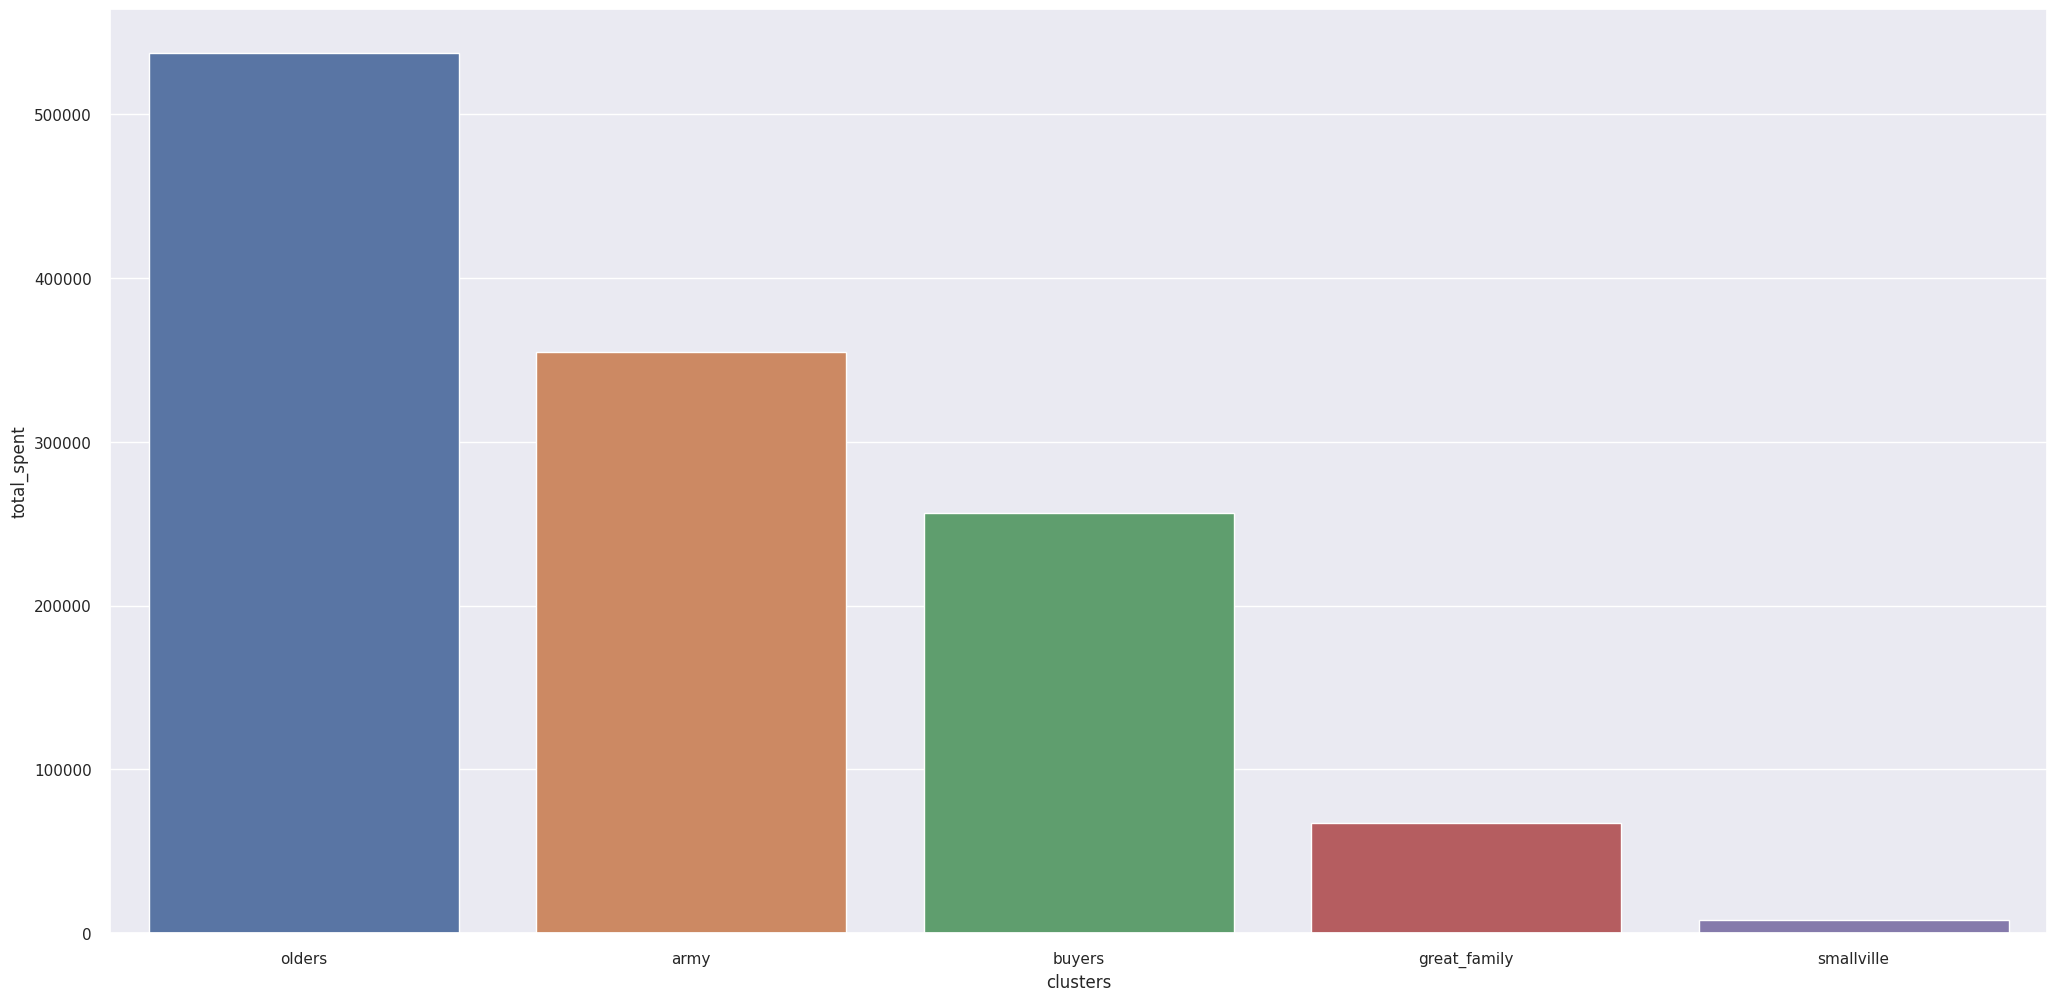

In [69]:
sns.barplot(x='clusters',y='total_spent',data=total_spent_clusters)
plt.savefig(path_local+'data/images/total_spent_clusters.png')

In [ ]:
total_spent_clusters['total_spent'] = total_spent_clusters['total_spent'].apply(lambda x: f'R$ {x:,.2f}')
total_spent_clusters

,clusters,total_spent
3,olders,"R$ 537,160.00"
0,army,"R$ 354,828.00"
1,buyers,"R$ 256,374.00"
2,great_family,"R$ 67,385.00"
4,smallville,"R$ 8,167.00"



### Quais as principais características do grupo mais rentável ?

In [89]:
# Filtrar o DataFrame df11 para incluir apenas as linhas onde a coluna "clusters" é igual a "olders"
df_older = df11[df11["clusters"]=="olders"]

columns = ['income', 'recency', 'mnt_wines', 'mnt_fruits', 'mnt_meat_products',
           'mnt_fish_products', 'mnt_sweet_products', 'mnt_gold_prods',
           'num_deals_purchases', 'num_web_purchases', 'num_catalog_purchases',
           'num_store_purchases', 'num_web_visits_month', 'age',
           'n_family_members', 'days_since_signup', 'income_per_member', 'total_spent']

confidence_intervals = calculate_confidence_intervals(columns, df11[df11["clusters"]=="olders"],0.9)

# Imprimir os resultados
for column, interval in confidence_intervals.items():
    print(f"Intervalo de Confiança para '{column}': {interval}")


Intervalo de Confiança para 'income': (54695.30682994145, 57525.01725764979)
Intervalo de Confiança para 'recency': (45.65890956038566, 49.30751379727858)
Intervalo de Confiança para 'mnt_wines': (355.0029530583715, 399.91967467885485)
Intervalo de Confiança para 'mnt_fruits': (33.39546235763811, 39.173880708055314)
Intervalo de Confiança para 'mnt_meat_products': (214.45980820723446, 246.07157865407942)
Intervalo de Confiança para 'mnt_fish_products': (48.762200597832674, 56.71809137297025)
Intervalo de Confiança para 'mnt_sweet_products': (33.5217074305021, 39.380482350519806)
Intervalo de Confiança para 'mnt_gold_prods': (47.56560690212239, 54.37891864532286)
Intervalo de Confiança para 'num_deals_purchases': (1.7207219384462416, 1.8938766016997435)
Intervalo de Confiança para 'num_web_purchases': (4.195342966563859, 4.517065792560229)
Intervalo de Confiança para 'num_catalog_purchases': (3.254462784599207, 3.6331284562767054)
Intervalo de Confiança para 'num_store_purchases': (6.17

In [90]:
df_intervals = pd.DataFrame(confidence_intervals,index=['inferior','superior']).T.reset_index().rename(columns={'index':'variavel'})
df_intervals

,variavel,inferior,superior
0,income,54695.306830,57525.017258
1,recency,45.658910,49.307514
2,mnt_wines,355.002953,399.919675
3,mnt_fruits,33.395462,39.173881
4,mnt_meat_products,214.459808,246.071579
5,mnt_fish_products,48.762201,56.718091
6,mnt_sweet_products,33.521707,39.380482
7,mnt_gold_prods,47.565607,54.378919
8,num_deals_purchases,1.720722,1.893877
9,num_web_purchases,4.195343,4.517066


### Qual a porcentagem de contribuição do faturamento, vinda do grupo ?


In [94]:
perc = round(df11[df11["clusters"]=="olders"]["total_spent"].sum()/df11["total_spent"].sum(),2)*100
print(perc,'%')

44.0 %
